# Topic Modeling Cluster Analysis

Goal: provide general clustering technique using K-means and Gaussian mixture modeling to take an input corpus of documents and output a set of themes, keywords, and cluster assignments for each document.
Current Application: Use to create clusters and keyword themes for the photovoltaic research space using PVSC abstracts.

In [42]:
##--CURRENT GOALS:
#----LEARN gensim, then try clustering using word distributions form LDA - try hierarchical
#-1) Assign topic names to LDA output clusters, compare with GMM, then figure out questions to answer
#---2) LDA not working well!  Try maybe removing topic number limit to see if it does better with more vocabulary
#---3) Also, move to separate file so LSA method separate from LDA
#--QUESTIONS TO ANSWER AND VISUALIZATIONS TO ANSWER THEM
#-1) Output for all years together a year-based trend of topics
#-2) Distances between clusters

##--TEXT ANALYSIS PROJECT: Developing tools to connect funding opportunities, awards, and industry trends
#-----OUTPUTS---#
#--Five files are generated if entire program is run:
#--1) Corpus documents with related info
#--2) KM cluster descriptions with count
#--3) EM cluster descriptions with count
#--4) KM cluster distances
#--5) EM cluster distances

#-----Steps-----#
#1) Develop functions that allow choice of method for each step:
#---1/2A) Read in files
#---A) vocabulary set
#---C) dimensionality reduction
#---B) similarity measure
#---D) clustering technique - DO LDA as DR, then GMM using probabilities as features
#---E) visualization
#---F) output - start doing analyses across years
#2) Systematically compare methods using funded/unfunded, etc., - do with PVRD, NGII, FPACE, look at 2016

In [43]:
##NOTES##
#7/16/2017: at least 1600 topic threshold is important for all years combined (600 for one year), otherwise sometimes some docs don't have topic words in them and they create larger cluster with wide variety of topics in it
#4/23/2017: analyzer 'word' for Count and tfidf Vectorizer does better job of getting rid of two-letter phrases that end up dominating frequency and labels
#-----------This also makes C-S metrics perform better at finding optimal cluster size (plateaus around 20)
#4/23/2017: generic stopmajor list does OK

In [3]:
#-SYS IMPORTS
from __future__ import print_function
import sys
#sys.path.append('N:/Trinastic/pythonLib/python-rake-master')
#import RAKE

import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import os
import codecs
import re
import string
#MATPLOTLIB IMPORTS
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')
%matplotlib inline

#PLOTLY IMPORTS - Offline version
import plotly as py
import plotly.offline as pyo
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
pyo.init_notebook_mode(connected=True)

#-NTLK IMPORTS
import nltk
from nltk.stem.snowball import SnowballStemmer as snowstem
stemmer = snowstem("english")
from nltk.stem import WordNetLemmatizer
#-RAKE IMPORTS
import RAKE #(python-rake) - RAKE keyword extraction based on Berry & J. Kogan (Eds.), Text Mining: Theory and Applications

#-SKLEARN IMPORTS
from sklearn.model_selection import train_test_split
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_samples
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.neighbors import KNeighborsClassifier

#-SCIPY IMPORTS
import scipy.sparse as sparse

In [4]:
##---PARAMETERS--##
#----These are the primary parameters that should be changed to alter code output!

#-INPUT: Parameters to determine input data
#Note: Abs and FOAs will be string input, inputApps will be list of strings, each element corresponding to FOA
#inputAbs = '2015'
inputAbs = 'all'

#inputFOAs = 'allFOAs'
inputFOAs = None

inputApps = []
#inputApps = ['BRIDGE', 'FPACE1', 'FPACE2', 'NG2', 'NG3', 'PVRD1', 'PVRD2']

#Create nameApps parameter for naming output files
nameApps = ''
for name in inputApps:
    nameApps = nameApps + '_' + name

#-GROUPING: Parameters to determine what fields to group for use as text analysis corpus
columnsGrouping = ['Title', 'Abstract']
titleGrouping = 'Title and Abstract'
titleGroupingStem = 'Title and Abstract Stem'
#--Parameters to determine what characters to remove from corpus
#--Goal is to remove variance in how same phrases are written
RemoveNoSpaceList = ["\(", "\)", r",(?=[^\d\s])"]
RemoveSpaceList = ["/", ":", "  ", "-", "–", "−"]

#-STOPMAJORS: Provide StopMajor List - determine this based on feedback to ensure only meaningful themes
#Others to think about - device, film, model, module
addSM = ['pv', 'photovolta', 'solar', 'process', 'quantum', 'use', 'respons', 'measur', 'result', 'propos', 'page',
        'page', 'page contain proprietari inform', 'observ', 'method', 'technolog', 'properti', 'output',
        'superior', 'player', 'includ', 'effect', 'influenc', 'enhanc', 'foa', 'defoa0001387 control',
        'defoa0001387', 'pvrd']
'''addSM = ['pv', 'photovoltaic', 'photovoltaics', 'solar', 'process', 'processes', 'method', 'proposed method',
            'technology', 'technologies', 'property', 'properties', 'output', 'rate', 'quantum', 'using', 'used',
            'uses', 'use', 'superior', 'player', 'including', 'observe', 'observed', 'observing', 'observes',
            'effect', 'effects', 'influence', 'influences', 'page', 'page contains proprietary information',
            'middle', 'innovative', 'enhancing', 'concepts', 'proposed', 'propose', 'analysis', 'solar cells using',
            'result', 'results', 'measure', 'measured', 'responsible']
'''

#-VOCAB CREATION: 
#--Parameter for what type of vocabulary to use (words, RAKE, words+RAKE, etc.)
vocabType = "words_RAKE"

#-FREQUENCY FILTER:
#--Minimum number of words to include in each phrase in vocabulary (1 would allow 1+ words in phrase, for example)
minWordphrase = 1
#--Minimum Frequency Factor is minimum frequency to include
minFreqScaleFactor = 15
#--Maximum Frequency Factor is a fraction of total number of corpus times average length
maxFreqScaleFactor = 0.9

#-TOPICALITY FILTER:
#--Threshold below which to keep vocabulary terms (1 indicates expected word distribution throughout corpus)
ccThreshold = 0.9
#--Scaling factor to prefer multiple word phrases (>1 indicates stronger phase preference)
phasePreference = 1.0

#-CORRELATION FILTER:
#--Remove vocabulary term with higher CC ratio if has correlation over threshold with another term
corrThreshold = 0.7

#-POST-FREQUENCY FILTER:
#--Turn on post frequency filter to test different minimum frequencies after vocab processing steps above
postFreqSwitch = 'on'

#-TOPIC THRESHOLD:
#--Determines number of terms to use in topic set - only uses this top number based on CC ratio
#--Guidance: For single year, need at least 400; for all PVSC years plus all FOAS, need around 1200-2000 for accurate clustering
#---Determine exact amount necessary thru testing
topicThresh = 1500

In [5]:
##---FUNCTIONS---##

In [6]:
#-Function that loads all PVSC abstracts into a dataframe, where each column corresponds to one piece of information from abstract
def LoadPVSCabstractsPandas(folderPVSC=None, folderFOA=None, folderAPP=None):
    #--Parameters
    #-----pvscfolder: folder name from which to read pvsc abstract text files
    #-----foafolder: folder name from which to read FOA text information
    #-----appfolder: folder name from which to read application information
    #--End Parameters

    df = pd.DataFrame() #initialize empty dataframe to append all corpus documents

    #PVSC Folder additions
    if folderPVSC == 'all': #Use abstracts from all years
        PVSCnum = [33, 34, 35, 37, 38, 39, 40, 42, 43]  #list of PVSC year number to use in for loops
        numAbstractsByYear = [485, 529, 798, 884, 851, 800, 824, 859, 832]  #list of number of abstracts for each year, to use in for loops
    elif folderPVSC == '2016': #input only 2008 abstracts
        PVSCnum = [43]
        numAbstractsByYear = [832]
    elif folderPVSC == '2015': #input only 2008 abstracts
        PVSCnum = [42]
        numAbstractsByYear = [859]
    elif folderPVSC == '2014': #input only 2008 abstracts
        PVSCnum = [40]
        numAbstractsByYear = [824]      
    elif folderPVSC == '2013': #input only 2008 abstracts
        PVSCnum = [39]
        numAbstractsByYear = [800]      
    elif folderPVSC == '2012': #input only 2008 abstracts
        PVSCnum = [38]
        numAbstractsByYear = [851]      
    elif folderPVSC == '2011': #input only 2008 abstracts
        PVSCnum = [37]
        numAbstractsByYear = [884]      
    elif folderPVSC == '2010': #input only 2008 abstracts
        PVSCnum = [35]
        numAbstractsByYear = [798]      
    elif folderPVSC == '2009': #input only 2008 abstracts
        PVSCnum = [34]
        numAbstractsByYear = [529]
    elif folderPVSC == '2008': #input only 2008 abstracts
        PVSCnum = [33]
        numAbstractsByYear = [485]
    elif folderPVSC == None:
        print("No PVSC abstracts loaded.")
    else: sys.exit("Error: valid folderPVSC parameter not selected!")
    
    if folderPVSC != None:
        for i in range(len(PVSCnum)):
            for j in range(0,numAbstractsByYear[i]):
                number = "%03d" % j #create the number of the PVSC abstract with three digits as the text file is named
                inputTmp = "../AllPVSCAbstracts/PVSC" + str(PVSCnum[i]) + "_formatted_" + number + ".txt"
                dfTmp = pd.read_csv(inputTmp, header=None, names = ["Abstract Info"], sep="\n", engine="python")
                replaceList = ["Author(s): ", "Title: ", "Misc_Pub_Info: ", "Start_Date: ", "DOI: ", "Abstract: ", "Keywords: ", "URL: "]
                for k in range(len(replaceList)): #Remove label name from each cell in dataframe
                    dfTmp["Abstract Info"][k] = dfTmp["Abstract Info"][k].replace(replaceList[k], "")
                dfTmp.rename({0: "Author(s)", 1: "Title", 2: "Misc Pub Info", 3: "Start Date", 4: "DOI", 5: "Abstract", 6: "Keywords", 7: "URL"}, inplace=True)
                dfTmp = dfTmp.T
                df = df.append(dfTmp)

    #FOA Folder additions
    if folderFOA == 'allFOAs':
        dirFOA = "../FOAs-Formatted/"
        for file in os.listdir(dirFOA):
            dfTmp = pd.read_csv(dirFOA + file, header=None, names = ["Abstract Info"], sep="\n", engine="python")
            replaceList = ["Author(s): ", "Title: ", "Misc_Pub_Info: ", "Start_Date: ", "DOI: ", "Abstract: ", "Keywords: ", "URL: "]
            for k in range(len(replaceList)): #Remove label name from each cell in dataframe
                dfTmp["Abstract Info"][k] = dfTmp["Abstract Info"][k].replace(replaceList[k], "")
            dfTmp.rename({0: "Author(s)", 1: "Title", 2: "Misc Pub Info", 3: "Start Date", 4: "DOI", 5: "Abstract", 6: "Keywords", 7: "URL"}, inplace=True)
            dfTmp = dfTmp.T
            df = df.append(dfTmp)
    elif folderFOA == None:
        print("No FOA abstracts loaded.")
    else: sys.exit("Error: valid folderFOA parameter not selected!")

    #Application additions - input should be list, checks if keyword is contained in list
    if 'BRIDGE' in folderAPP:
        dirAPP = "../BRIDGE/Tech Vols - Intro and Research Plan Formatted/"
        for file in os.listdir(dirAPP):
            dfTmp = pd.read_csv(dirAPP + file, header=None, names = ["Abstract Info"], sep="\n", engine="python")
            replaceList = ["Author(s): ", "Title: ", "Misc_Pub_Info: ", "Start_Date: ", "DOI: ", "Abstract: ", "Keywords: ", "URL: "]
            for k in range(len(replaceList)): #Remove label name from each cell in dataframe
                dfTmp["Abstract Info"][k] = dfTmp["Abstract Info"][k].replace(replaceList[k], "")
            dfTmp.rename({0: "Author(s)", 1: "Title", 2: "Misc Pub Info", 3: "Start Date", 4: "DOI", 5: "Abstract", 6: "Keywords", 7: "URL"}, inplace=True)
            dfTmp = dfTmp.T
            df = df.append(dfTmp)
    if 'FPACE1' in folderAPP:
        dirAPP = "../FPACE1/Technical Volumes - PDF2Text - Remove Front Page, Refs, Bio Sketch, LoS - Formatted/"
        for file in os.listdir(dirAPP):
            dfTmp = pd.read_csv(dirAPP + file, header=None, names = ["Abstract Info"], sep="\n", engine="python")
            replaceList = ["Author(s): ", "Title: ", "Misc_Pub_Info: ", "Start_Date: ", "DOI: ", "Abstract: ", "Keywords: ", "URL: "]
            for k in range(len(replaceList)): #Remove label name from each cell in dataframe
                dfTmp["Abstract Info"][k] = dfTmp["Abstract Info"][k].replace(replaceList[k], "")
            dfTmp.rename({0: "Author(s)", 1: "Title", 2: "Misc Pub Info", 3: "Start Date", 4: "DOI", 5: "Abstract", 6: "Keywords", 7: "URL"}, inplace=True)
            dfTmp = dfTmp.T
            df = df.append(dfTmp)
    if 'FPACE2' in folderAPP:
        dirAPP = "../FPACE2/Technical Volumes - Intro and Research Plan Formatted/"
        for file in os.listdir(dirAPP):
            dfTmp = pd.read_csv(dirAPP + file, header=None, names = ["Abstract Info"], sep="\n", engine="python")
            replaceList = ["Author(s): ", "Title: ", "Misc_Pub_Info: ", "Start_Date: ", "DOI: ", "Abstract: ", "Keywords: ", "URL: "]
            for k in range(len(replaceList)): #Remove label name from each cell in dataframe
                dfTmp["Abstract Info"][k] = dfTmp["Abstract Info"][k].replace(replaceList[k], "")
            dfTmp.rename({0: "Author(s)", 1: "Title", 2: "Misc Pub Info", 3: "Start Date", 4: "DOI", 5: "Abstract", 6: "Keywords", 7: "URL"}, inplace=True)
            dfTmp = dfTmp.T
            df = df.append(dfTmp)
    if 'NG2' in folderAPP:
        dirAPP = "../NG2/FullNarratives_pdftotext_Formatted_NoRefNoBibNoResumes/"
        for file in os.listdir(dirAPP):
            dfTmp = pd.read_csv(dirAPP + file, header=None, names = ["Abstract Info"], sep="\n", engine="python")
            replaceList = ["Author(s): ", "Title: ", "Misc_Pub_Info: ", "Start_Date: ", "DOI: ", "Abstract: ", "Keywords: ", "URL: "]
            for k in range(len(replaceList)): #Remove label name from each cell in dataframe
                dfTmp["Abstract Info"][k] = dfTmp["Abstract Info"][k].replace(replaceList[k], "")
            dfTmp.rename({0: "Author(s)", 1: "Title", 2: "Misc Pub Info", 3: "Start Date", 4: "DOI", 5: "Abstract", 6: "Keywords", 7: "URL"}, inplace=True)
            dfTmp = dfTmp.T
            df = df.append(dfTmp)
    if 'NG3' in folderAPP:
        dirAPP = "../NG3/Tech Vol - Intro and Research Plan Formatted/"
        for file in os.listdir(dirAPP):
            dfTmp = pd.read_csv(dirAPP + file, header=None, names = ["Abstract Info"], sep="\n", engine="python")
            replaceList = ["Author(s): ", "Title: ", "Misc_Pub_Info: ", "Start_Date: ", "DOI: ", "Abstract: ", "Keywords: ", "URL: "]
            for k in range(len(replaceList)): #Remove label name from each cell in dataframe
                dfTmp["Abstract Info"][k] = dfTmp["Abstract Info"][k].replace(replaceList[k], "")
            dfTmp.rename({0: "Author(s)", 1: "Title", 2: "Misc Pub Info", 3: "Start Date", 4: "DOI", 5: "Abstract", 6: "Keywords", 7: "URL"}, inplace=True)
            dfTmp = dfTmp.T
            df = df.append(dfTmp)
    if 'PVRD1' in folderAPP:
        dirAPP = "../PVRD/PVRD Topic 2 and 3 Tech Vols/Technical_Volumes_thru_Workplan_Formatted/"
        for file in os.listdir(dirAPP):
            dfTmp = pd.read_csv(dirAPP + file, header=None, names = ["Abstract Info"], sep="\n", engine="python")
            replaceList = ["Author(s): ", "Title: ", "Misc_Pub_Info: ", "Start_Date: ", "DOI: ", "Abstract: ", "Keywords: ", "URL: "]
            for k in range(len(replaceList)): #Remove label name from each cell in dataframe
                dfTmp["Abstract Info"][k] = dfTmp["Abstract Info"][k].replace(replaceList[k], "")
            dfTmp.rename({0: "Author(s)", 1: "Title", 2: "Misc Pub Info", 3: "Start Date", 4: "DOI", 5: "Abstract", 6: "Keywords", 7: "URL"}, inplace=True)
            dfTmp = dfTmp.T
            df = df.append(dfTmp)
    if 'PVRD2' in folderAPP:
        dirAPP = "../PVRD2/Topics 2 and 3/Tech Vol Intro and Work Plan - Formatted/"
        for file in os.listdir(dirAPP):
            dfTmp = pd.read_csv(dirAPP + file, header=None, names = ["Abstract Info"], sep="\n", engine="python")
            replaceList = ["Author(s): ", "Title: ", "Misc_Pub_Info: ", "Start_Date: ", "DOI: ", "Abstract: ", "Keywords: ", "URL: "]
            for k in range(len(replaceList)): #Remove label name from each cell in dataframe
                dfTmp["Abstract Info"][k] = dfTmp["Abstract Info"][k].replace(replaceList[k], "")
            dfTmp.rename({0: "Author(s)", 1: "Title", 2: "Misc Pub Info", 3: "Start Date", 4: "DOI", 5: "Abstract", 6: "Keywords", 7: "URL"}, inplace=True)
            dfTmp = dfTmp.T
            df = df.append(dfTmp)
    elif not folderAPP:
        print("No application abstracts loaded.")
    #else: sys.exit("Error: valid folderAPP parameter not selected!")
        
    df = df.reset_index(drop=True)
    df['Start Date'] = df['Start Date'].apply(lambda x: pd.to_datetime(x))
    return df

In [7]:
#-Function gives different ways of grouping list elements into one so that different combinations can be used for the cluster analysis
#-Function also takes as input symbols/letters to be used to remove from the data that we don't want counted as differentiating words in the vocabulary
def GroupFields(dfAbstracts, groupList, groupName, removeNoSpace, removeSpace):
    #--Parameters
    #-----dfAbstracts: dataframe with abstract info
    #-----groupList: list of df columns to add together, always added together left to right.
    #-----groupName: name of new df column created
    #-----removeList: list of string characters to be removed for corpus
    #--End Parameters    

    dfAbstracts[groupName] = dfAbstracts[groupList[0]]
    for i in range(1,len(groupList)):
        dfAbstracts[groupName] = dfAbstracts[groupName] + ". " + dfAbstracts[groupList[i]]
    
    #Remove symbols of choice from column that will be used for clustering input
    for i in range(len(removeNoSpace)):
        dfAbstracts[groupName] = dfAbstracts[groupName].replace({removeNoSpace[i] : ""}, regex=True)
    for i in range(len(removeSpace)):
        dfAbstracts[groupName] = dfAbstracts[groupName].replace({removeSpace[i] : " "}, regex=True)     
    
    #Change '+' to 'plus', as '++' can give regex problems later in code
    dfAbstracts[groupName] = dfAbstracts[groupName].replace({'\+' : "plus"}, regex=True)
    #Change '*' to '' since this doesn't provide meaning and provides regex problems with pandas
    dfAbstracts[groupName] = dfAbstracts[groupName].replace({'\*' : ""}, regex=True)
        
    #Remove all uppercase letters to be sure that corpus matches vocabulary
    dfAbstracts[groupName] = dfAbstracts[groupName].apply(lambda x : x.lower())
    
    return dfAbstracts

In [8]:
#-Function to set stopwords list
#--Available stopword lists ('type' parameter):
#---1) 'nltk-english': standard nltk english word list
#---2) 'inspire': standard INSPIRE stopwords (PNNL)
def SetStopMajors(smType, addons=None):
    #--Parameters:
    #----type: name of standard stopword list to use
    #----addons: list of addons to add in addition to standard list chosen
    #--End Parameters

    stemmer = snowstem("english")
    
    if smType == 'nltk-english':
        stopmajors = nltk.corpus.stopwords.words('english')
    elif smType == 'inspire':
        stopmajors = open('swINSPIRE.txt').read().split('\n') #list of INSPIRE stopwords
    else:
        sys.exit("Error: Incorrect stopmajors type chosen!")
    
    #Add on any additional stopwords to original list
    if addons != None:
        for i in range(len(addons)):
            stopmajors.append(addons[i])

    #Create stemmed version of stopmajors list
    stopmajorsStem = [stemmer.stem(t) for t in stopmajors]
    
    return stopmajorsStem, stopmajors

In [9]:
#---Vocabulary Definition Functions---#
#-First three functions feed into final DefineVocabulary definition that creates word/phrase set to input into feature extraction

#Functions to implement stemmer as tokenizer
def StemmerCustom(tokens, stemmer):
    stems = [stemmer.stem(item) for item in tokens]
    return stems

def TokenizeCustom(text):
    tokens = nltk.word_tokenize(text)
    filtered = [token.lower().replace('-', ' ') for token in tokens if re.search('[a-zA-Z]', token) is not None]
    stems = StemmerCustom(filtered, stemmer)
    return stems

#-Tokenize and stem input text and return pd Series of stemmed words without hyphens
def TokenizeAndStem(text):
    #--Parameters:
    #----text: input text to tokenize as string
    #--End Parameters
    
    # first tokenize, then stem, then put into dataframe
    stems = TokenizeCustom(text)
    sStems = pd.Series(data=stems)
    return sStems

#-Tokenize input text and return pd Series of words without hyphens
def Tokenize(text):
    #--Parameters:
    #----text: input text to tokenize as string
    #--End Parameters
    
    # first tokenize, then put into dataframe
    tokens = nltk.word_tokenize(text)
    filtered = [token.lower().replace('-', ' ') for token in tokens if re.search('[a-zA-Z]', token) is not None]
    sFilteredTokens = pd.Series(data=filtered)
    return sFilteredTokens

#-Function to run over all documents in corpus dataframe and create entire vocabulary with and without stemming
def TokenizeVocab(dfInput):
    #--Parameters:
    #----dataInput: input corpus of documents from which to create vocabulary
    #--End Parameters

    #Initialize pd Series that will be filled with Stemmed and non-stemmed vocabularies
    vocabStemmed = pd.Series()
    vocabTokenized = pd.Series()
    
    #Fill Series with vocabulary words from each input text
    for i in range(len(dfInput)):
        allWordsStemmed = TokenizeAndStem(dfInput.iloc[i]) #for each item in dfInput, tokenize/stem
        vocabStemmed = vocabStemmed.append(allWordsStemmed) #append the 'totalVocabStemmed' df to stemmed vocab df
    
        allWordsTokenized = Tokenize(dfInput.iloc[i])
        vocabTokenized = vocabTokenized.append(allWordsTokenized)
    
    #Remove duplicates
    vocabStemmed = vocabStemmed.drop_duplicates()
    vocabTokenized = vocabTokenized.drop_duplicates()
    
    #Reset indices for stemmed and tokenized vocab lists
    vocabStemmed.reset_index(drop=True, inplace=True)
    vocabTokenized.reset_index(drop=True, inplace=True)
  
    return vocabStemmed, vocabTokenized

#-Function to run over all documents in corpus dataframe and create entire vocabulary without stemming only
def TokenizeVocabNoStem(dfInput):
    #--Parameters:
    #----dataInput: input corpus of documents from which to create vocabulary
    #--End Parameters

    #Initialize pd Series that will be filled with Stemmed and non-stemmed vocabularies
    vocabTokenized = pd.Series()
    
    #Fill Series with vocabulary words from each input text
    for i in range(len(dfInput)):
        allWordsTokenized = Tokenize(dfInput.iloc[i])
        vocabTokenized = vocabTokenized.append(allWordsTokenized)
    
    #Remove duplicates
    vocabTokenized = vocabTokenized.drop_duplicates()
    
    #Reset indices for stemmed and tokenized vocab lists
    vocabTokenized.reset_index(drop=True, inplace=True)
  
    return vocabTokenized

In [10]:
#Function that stems each word in multi-word phrase and recompiles as single string

def StemmerMultiWord(inString):
    stems = TokenizeCustom(inString)
    return ' '.join(stems)  

#-Function to determine vocabulary set using Tokenize functions above - using stemmed vocab not currently implemented!
def DefineVocabulary(dfInput, vType, smList, swFile=[], scoreLower=None, scoreUpper=None, userList = []):
    #--Parameters:
    #---vType: multiple ways of creating vocabulary:
    #------1) 'words': single words only
    #------2) 'RAKE': use RAKE algorithm to get key phrases
    #------3) 'words_RAKE': single words plus RAKE phrases
    #------4) 'word_RAKE_user': single words plus RAKE phrases plus user-added phrases (this is INSPIRE's list)
    #---smList: stopmajor list that must be read in from file
    #---scoreLower is the minimum RAKE score required to be added as keyword
    #---scoreUpper is the maximum RAKE score allowed to be added as keyword
    #---userList is list of user-input words or phrases to include in vocabulary
    #--End Parameters
    
    if vType == 'words':
        finalVocab = TokenizeVocabNoStem(dfInput)

        #Remove duplicates
        finalVocabNoDup = finalVocab.drop_duplicates(keep='first')       

        #Place in dataframe with 'Phrase' column to match other possible outputs and used as label for later code
        dfFinalVocabNoDup = pd.DataFrame(finalVocabNoDup, columns=['Phrase'])
        
        #Apply stemming and create new column with stem
        dfFinalVocabNoDup['Stem'] = dfFinalVocabNoDup['Phrase'].apply(lambda x : StemmerMultiWord(x))
        
        #Remove duplicates of combined dataframe
        dfFinalVocabNoDup = dfFinalVocabNoDup.drop_duplicates(subset='Stem', keep='first')
        
        #Remove stopmajors
        for i in range(len(smList)):
            dfFinalVocabNoDup = dfFinalVocabNoDup[dfFinalVocabNoDup['Stem'] != smList[i]]
        
        #Reset indices on vocabulary series
        dfFinalVocabNoDup.reset_index(drop=True, inplace=True)
    
        return dfFinalVocabNoDup
  
    elif vType == 'RAKE':
        vocabRAKE = pd.DataFrame(columns=['Phrase', 'Score']) #initialize list of RAKE keywords passing score thresholds to be used for vocabulary
        
        for i in range(len(dfInput)):
            Rake = RAKE.Rake(swFile) #enter stopword list to use
            docRAKE = Rake.run(dfInput.iloc[i]) #create a RAKE keyword list for ith document in corpus
            #use list comprehension to put values in docRAKE tuples into dataframe
            tmpDfRAKE = pd.DataFrame({'Phrase':[row[0] for row in docRAKE], 'Score' : [row[1] for row in docRAKE]})
            vocabRAKE = vocabRAKE.append(tmpDfRAKE) #append to vocabulary if RAKE score within limits

        vocabRAKE = vocabRAKE[(vocabRAKE['Score'] > scoreLower) & (vocabRAKE['Score'] < scoreUpper)]

        #Remove duplicates
        vocabRAKENoDup = vocabRAKE.drop_duplicates(subset='Phrase', keep='first')       

        #Apply stemming and create new column with stem
        finalVocabRAKENoDup['Stem'] = vocabRAKENoDup['Phrase'].apply(lambda x : StemmerMultiWord(x))

        #Remove duplicates
        finalVocabRAKENoDup = finalVocabRAKENoDup.drop_duplicates(subset='Stem', keep='first') 
        
        #Remove stopmajors
        for i in range(len(smList)):
            finalVocabRAKENoDup = finalVocabRAKENoDup[finalVocabRAKENoDup['Stem'] != smList[i]]
        
        #Reset indices on vocabulary series
        finalVocabRAKENoDup.reset_index(drop=True, inplace=True)
        
        return finalVocabRAKENoDup
  
    elif vType == 'words_RAKE':
        #--WORD term creation--#
        finalVocab = TokenizeVocabNoStem(dfInput)

        #Remove duplicates
        finalVocabNoDup = finalVocab.drop_duplicates(keep='first')       
     
        #Reset indices on vocabulary series
        finalVocabNoDup.reset_index(drop=True, inplace=True)
    
        #Create dataframe with two columns for single words dataframe to connect to RAKE dataframe
        dfFinalVocab = pd.DataFrame(finalVocabNoDup, columns=['Phrase'])
        #Create 'Count' column with all values of 1 (since all single word)
        dfFinalVocab['Score'] = 1
        
        #--RAKE term creation--#
        vocabRAKE = pd.DataFrame(columns=['Phrase', 'Score']) #initialize list of RAKE keywords passing score thresholds to be used for vocabulary
        
        for i in range(len(dfInput)):
            Rake = RAKE.Rake(swFile) #enter stopword list to use
            docRAKE = Rake.run(dfInput.iloc[i]) #create a RAKE keyword list for ith document in corpus
            #use list comprehension to put values in docRAKE tuples into dataframe
            tmpDfRAKE = pd.DataFrame({'Phrase':[row[0] for row in docRAKE], 'Score' : [row[1] for row in docRAKE]})
            vocabRAKE = vocabRAKE.append(tmpDfRAKE) #append to vocabulary if RAKE score within limits

        vocabRAKE = vocabRAKE[(vocabRAKE['Score'] > scoreLower) & (vocabRAKE['Score'] < scoreUpper)]

        #Remove duplicates
        vocabRAKENoDup = vocabRAKE.drop_duplicates(subset='Phrase', keep='first')       

        #--COMBINED word+RAKE creation--##
            
        #Append original single word vocabulary
        dfRAKEplusWord = vocabRAKENoDup.append(dfFinalVocab)
      
        #Apply stemming and create new column with stem
        dfRAKEplusWord['Stem'] = dfRAKEplusWord['Phrase'].apply(lambda x : StemmerMultiWord(x))
    
        #Remove duplicates of combined dataframe
        finalvocabInitialNoDupNoSM = dfRAKEplusWord.drop_duplicates(subset='Stem', keep='first')
               
        #Remove stopmajors
        for i in range(len(smList)):
            finalvocabInitialNoDupNoSM = finalvocabInitialNoDupNoSM[finalvocabInitialNoDupNoSM['Stem'] != smList[i]]
            
        #Reset indices on vocabulary series
        finalvocabInitialNoDupNoSM.reset_index(drop=True, inplace=True)
      
        return finalvocabInitialNoDupNoSM
    
    elif vType == 'words_RAKE_user':
        #--WORD term creation--#
        finalVocab = TokenizeVocabNoStem(dfInput)

        #Remove duplicates
        finalVocabNoDup = finalVocab.drop_duplicates(keep='first')       
      
        #Reset indices on vocabulary series
        finalVocabNoDup.reset_index(drop=True, inplace=True)
    
        #Create dataframe with two columns for single words dataframe to connect to RAKE dataframe
        dfFinalVocab = pd.DataFrame(finalVocabNoDup, columns=['Phrase'])
        #Create 'Count' column with all values of 1 (since all single word)
        dfFinalVocab['Score'] = 1
        
        #--RAKE term creation--#
        vocabRAKE = pd.DataFrame(columns=['Phrase', 'Score']) #initialize list of RAKE keywords passing score thresholds to be used for vocabulary
        
        for i in range(len(dfInput)):
            Rake = RAKE.Rake(swFile) #enter stopword list to use
            docRAKE = Rake.run(dfInput.iloc[i]) #create a RAKE keyword list for ith document in corpus
            #use list comprehension to put values in docRAKE tuples into dataframe
            tmpDfRAKE = pd.DataFrame({'Phrase':[row[0] for row in docRAKE], 'Score' : [row[1] for row in docRAKE]})
            vocabRAKE = vocabRAKE.append(tmpDfRAKE) #append to vocabulary if RAKE score within limits

        vocabRAKE = vocabRAKE[(vocabRAKE['Score'] > scoreLower) & (vocabRAKE['Score'] < scoreUpper)]

        #Remove duplicates
        vocabRAKENoDup = vocabRAKE.drop_duplicates(subset='Phrase', keep='first')       

        #--COMBINED word+RAKE creation--##
            
        #Append original single word vocabulary
        dfRAKEplusWord = vocabRAKENoDup.append(dfFinalVocab)

        #Append user-entered list - give score of 1 for all user entries
        for i in range(len(userList)):
            tmpUser = pd.DataFrame([(userList[i], 1)], columns = ['Phrase', 'Score'])
            dfRAKEplusWord = dfRAKEplusWord.append(tmpUser)
        
        #Apply stemming and create new column with stem
        dfRAKEplusWord['Stem'] = dfRAKEplusWord['Phrase'].apply(lambda x : StemmerMultiWord(x))
        
        #Remove duplicates of combined dataframe
        finalvocabInitialNoDupNoSM = dfRAKEplusWord.drop_duplicates(subset='Stem', keep='first')

        #Remove stopmajors
        for i in range(len(smList)):
            finalvocabInitialNoDupNoSM = finalvocabInitialNoDupNoSM[finalvocabInitialNoDupNoSM['Stem'] != smList[i]]
        
        #Reset indices on vocabulary series
        finalvocabInitialNoDupNoSM.reset_index(drop=True, inplace=True)
      
        return finalvocabInitialNoDupNoSM

    else:
        sys.exit("Error: Incorrect vType chosen!")

In [11]:
#Function that takes CountVectorizer dataframe (nDocs by nVocab) and counts frequency of each vocabulary element.
#If frequency is less than minFreq or more than maxFreq, removed for revised vocabulary (output)
def FreqFilter(dfCountIn, dfVocab, minFreq, maxFreq):
    #--Parameters:
    #----dfCountIn: input df with nDoc x nVocab countvectorizer matrix
    #----dfVocab: input df of vocabulary
    #----minFreq: minimum frequency count to pass frequency filter (raw count, not percent)
    #----maxFreq: maximum frequency count to pass frequency filter (raw count, not percent)
    
    dfOutput = dfVocab.copy() #initialize output df as current vocab
    dfOutput['Flag'] = 0 #set Flag to 0 for all elements
    
    #Calculate summed frequency for all vocab elements across documents (axis=0 indicates sum across indices)
    #Add word frequencies to vocab dataframe
    dfOutput['Frequency'] = dfCountIn.sum(axis=0)
    
    # If count for one vocab element is above minfreq and below maxfreq, set flag to 1
    dfOutput['Flag'] = np.where((dfOutput['Frequency'] > minFreq) & (dfOutput['Frequency'] < maxFreq), 1, 0)

    # Only keep those words within freq range
    dfRejected = dfOutput[dfOutput['Flag'] == 0]
    dfOutput = dfOutput[dfOutput['Flag'] == 1]
    
    
    dfOutput.reset_index(drop=True, inplace=True)
   
    return dfOutput, dfRejected

In [12]:
#Input column from dataframe and desired search term as string, will output all rows of the entire dataframe where term is found
#If multiple search terms folllowed by space, broken up such that each word is searched for separately (don't have to occur sequentially)
def ColumnSearchRowOut(dfInput, colName, searchTerm):
    #--Parameters:
    #---dfInput: input dataframe
    #---colName: name of column in dfInput to run search over
    #---searchTerm: term to search over desired column
    
    #First, create base mask filled with Trues (boolean type so & boolean works properly)
    mask = pd.Series(index=dfInput[colName].index)
    mask = mask.fillna(True).astype(bool)
    
    #Loop through each word in search term, multiply mask by the tmpMask created for each word
    for i in range(len(searchTerm.split())):
        tmpMask = dfInput[colName].str.contains(searchTerm.split()[i], case=False)
        mask = mask & tmpMask
    dfOutput = dfInput.loc[mask]
    
    return dfOutput

In [13]:
#Input column from dataframe and desired search term as string, will output all indices of the entire dataframe where term is found
def ColumnSearchIndOut(dfInput, colName, searchTerm):
    #--Parameters:
    #---dfInput: input dataframe
    #---colName: name of column in dfInput to run search over
    #---searchTerm: term to search over desired column

    #First, create base mask filled with Trues (boolean type so & boolean works properly)
    mask = pd.Series(index=dfInput[colName].index)
    mask = mask.fillna(True).astype(bool)
    
    #Loop through each word in search term, multiply mask by the tmpMask created for each word
    for i in range(len(searchTerm.split())):
        tmpMask = dfInput[colName].str.contains(searchTerm.split()[i], case=False)
        mask = mask & tmpMask
    indexOutput = dfInput.loc[mask].index.tolist()

    return indexOutput

In [14]:
#Distance function for vectors with dim dimensions
def distance(p0, p1, dim):
    sum = 0
    for i in range(0, dim):
        sum = sum + (p0[i] - p1[i])**2
    dist = np.sqrt(sum)
    return dist

In [15]:
#-Function to apply topicality filter by calculating condensation cluster strength for each word, as described in Bookstein et al and INSPIRE patent
#-A low number indicates the term occurs less frequently than expected based on a random distribution
#-This indicates it is a special topic that should be used as a topic term

#Function used in primary ClusterFilter function to calculate CC Ratio
def ccCalc(word, freq, corpusIn, columnIn, phasePrefer):
    #Define length of corpus
    nCorpus = len(corpusIn)
    
    #Calculate CC ratio
    nOccWord = freq # This is now just Norm Frequency column
    nOccDoc = len(corpusIn.loc[corpusIn[columnIn].str.contains(word, case=False)])
    CCnum = nOccDoc # Actual number of textual units containing word i
    CCden = nCorpus * (1 - ((1 - (1/nCorpus))**nOccWord)) # Expected number of textual units containing word i 
    CCratio = CCnum / CCden
    if (len(word.split()) > 1):  # Use Phase preference do divide cluster ratio by value for multiword vocabulary
        CCratio = CCratio / phasePrefer
        
    return CCratio

#-NOTE: Currently have simple phraseboost implementation by dividing cluster ratio by phasePref for multiword terms
def ClusterFilter(dfCorpusIn, colIn, dfVocabFreqIn, colVocab, dfCountIn, inCorpusScale, threshold, phasePref):
    #--Parameters:--#
    #---dfCorpusIn: dataframe with input corpus of documents
    #---colIn: column name in dfCorpusIn to use for text corpus
    #---dfVocabFreqIn: dataframe with vocabulary determined after frequency filtering applied
    #---colVocab: column in vocabulary df to use as vocabulary (e.g. Phrase or Stem)
    #---dfCountIn: dataframe with counts of each vocabulary across corpus
    #---threshold: CC ratio threshold so that vocab only consists of terms with CC ratio below value
    #---phasePref: Float value used to prefer multiword answers if desired by dividing cluster ratio score by it
    #---Assumes dfVocabFreqIn has column names 'Phrase' with each vocab term

    #Create new column in vocab df for CC Ratio and initialize to 1.0 as default
    dfOutput = dfVocabFreqIn.copy()
    #Scale frequencies by normalization value based on average document length, to be used in topicality filter step below
    dfCountMatFreqScaled = dfCountIn.multiply((1/inCorpusScale), axis=0)
    dfOutput['Norm Frequency'] = dfCountMatFreqScaled.sum(axis=0)
    
    #Set CC Ratio to one as default - to be updated below
    dfOutput['CC Ratio'] = 0.8
    
    #CC Ratio calculation loop - apply lambda to each row using ccCalc function above
    dfOutput['CC Ratio'] = dfOutput.apply(lambda row: ccCalc(row[colVocab], row['Norm Frequency'], 
                                                             dfCorpusIn, colIn, phasePref), axis=1)

    #Output new df's of accepted and rejected vocabulary terms
    dfVocabOut = dfOutput[dfOutput['CC Ratio'] < threshold]
    dfRejected = dfOutput[dfOutput['CC Ratio'] >= threshold]
    dfVocabOut.reset_index(drop=True, inplace=True)
    
    return dfVocabOut, dfRejected

In [16]:
#Function that calculates between all vocab elements, provies correlation filter for vocabulary
#--Each vector being correlated is the number of occurrences in each document in corpus
#--Vector will then be the length of the corpus, have two vectors to correlate correlation
#--For word pairs over correlation threshold, remove that with high cluster ratio
def CorrFilter(vocabIn, countMatIn, corrThreshold):
    #--Parameters:
    #---vocabIn: input vocabulary to which to apply correlation filter, must have 'CC Ratio' column (from ClusterRatio function)
    #---countMatIn: input count matrix from CountVectorizer acted on corpus using vocabIn
    #---corrThreshold: threshold, above which one of the word pair is removed based on cluster ratio
    #---NOTE: columns of countMatIn must be labeled as indices of vocabulary terms (0, 1, 2, ...)

    corrList = [] #initialize list to collect index values for those vocab terms to remove
    vocabOut = vocabIn.copy() #Create copy of vocab list
    vocabOut['Corr Flag'] = 1 #Create correlation flag - 1 will indicate to keep term, 0 will indicate to remove
    
    dfCorr = countMatIn.corr() #create correlation matrix
    
    for i in range(len(dfCorr)):
        dfTmp = dfCorr[dfCorr[i] > corrThreshold] #create df of those vocab terms above threshold
        dfTmp = dfTmp.drop(i, axis=0) #remove row with 1.0 correlation (same-word word pair)
        for j in range(len(dfTmp)): #loop through dfTmp, compare cluster ratio score, only keep those less than ith vocab term's ratio
            if vocabIn['CC Ratio'].loc[i] < vocabIn['CC Ratio'].loc[dfTmp.index.values[j]]:
                corrList.append(dfTmp.index.values[j]) #append index of high cluster ratio
            else:
                corrList.append(i) #append index
    
    corrListNoDup = list(set(corrList)) #remove duplicates 

    for i in range(len(corrListNoDup)): #loop over all indices to remove, set Corr Flag to 0
        vocabOut['Corr Flag'].loc[corrListNoDup[i]] = 0
    
    vocabOut.reset_index(drop=True, inplace=True)
    
    return dfCorr, vocabOut

In [17]:
#--Function to list vocabulary in ascending or descending order of frequency
def VocabFrequencySorter(dfInput, dfCol, vocabInput, numList = 10, typeOrder = 'descending'):
    if typeOrder == "ascending":
        for i in range(0,numList):
            freqIndex = dfInput.sum(axis=0).argsort()[i]
            print(freqIndex, " | ", vocabInput[dfCol].iloc[freqIndex], " | ", dfInput.sum(axis=0).iloc[freqIndex])
    elif typeOrder == "descending":
        for i in range(0,numList):    
            freqIndex = dfInput.sum(axis=0).argsort()[::-1].reset_index(drop=True)[i]
            print(freqIndex, " | ", vocabInput[dfCol].iloc[freqIndex], " | ", dfInput.sum(axis=0).iloc[freqIndex])
    else:
        sys.exit("Error: Incorrect typeOrder chosen (ascending or descending)!")

In [18]:
#--Function to perform LSA transformation on input vocabulary tf-idf data
def LSAcalculation(numSVD, dfInput):
    svdTmp = TruncatedSVD(n_components = numSVD)

    #Now fit and transform the TFIDF matrix created above
    lsa = svdTmp.fit_transform(dfInput)

    #Normalize LSA results
    normalizer = Normalizer(copy=False, norm='l2')
    LSAnorm = normalizer.transform(lsa)

    return svdTmp, LSAnorm

In [19]:
#--Function to calculate k-means clustering for various k and calculate scores to determine optimal cluster number
def KMeansClusteringLoop(minClust, maxClust, inInt, dfInput):
        listInertia = list()
        listSilScore = list()
        listChScore = list()

        for i in range(minClust,maxClust, inInt):
            numClusters = i #number of clusters to use
            KMmodel = KMeans(n_clusters=i) #create KMeans object
            KMmodel.fit(dfInput)
            labels = KMmodel.labels_
            listInertia.append(KMmodel.inertia_)
            silScore = metrics.silhouette_score(dfInput, labels, metric='euclidean')
            listSilScore.append(silScore)
            listChScore.append(metrics.calinski_harabaz_score(dfInput, labels))
            
        return listInertia, listSilScore, listChScore

#--Same function as above but uses train/testing sets with silhouette score as response measure
def KMeansClusteringLoopTest(minClust, maxClust, inInt, dfInput):
        listInertia = list()
        listSilScore = list()
        listChScore = list()
        
        train, test = train_test_split(dfInput)
        
        for i in range(minClust,maxClust, inInt):
            numClusters = i #number of clusters to use
            KMmodel = KMeans(n_clusters=i) #create KMeans object
            KMmodel.fit(train) #train model on training set
            labels = KMmodel.predict(test) #predict labels for test set
            listInertia.append(KMmodel.inertia_) #calculate inertia from training
            silScore = metrics.silhouette_score(test, labels, metric='euclidean') #calculate scores using test
            listSilScore.append(silScore)
            listChScore.append(metrics.calinski_harabaz_score(test, labels))
            
        return listInertia, listSilScore, listChScore

In [20]:
#--Function that applies LSA and K-Means in loop with increasing number of components to find optimal SVD component number
def LSAkmeansClusteringLoop(inMinSVD, inMaxSVD, inIntSVD, dfInput):
    listInertia = list()
    listSilScore = list()
    listChScore = list()
    for numComponents in range (inMinSVD, inMaxSVD, inIntSVD):
        #Perform LSA
        svdOutTmp, LSAnormOutTmp = LSAcalculation(numComponents, dfInput)
        
        #Kmeans
        KMmodelTmp = KMeans(n_clusters = numComponents)
        KMmodelTmp.fit(LSAnormOutTmp)
        labelsTmp = KMmodelTmp.labels_
        listInertia.append(KMmodelTmp.inertia_ / svdOutTmp.explained_variance_.sum())
        silScore = metrics.silhouette_score(LSAnormOutTmp, labelsTmp, metric = 'euclidean')
        listSilScore.append(silScore * svdOutTmp.explained_variance_.sum())
        #The SVD variance weighting is scquared for C-H score because uses dispersion
        listChScore.append(metrics.calinski_harabaz_score(LSAnormOutTmp, labelsTmp) *
                           (np.power(svdOutTmp.explained_variance_.sum(),1)))
        
    return listInertia, listSilScore, listChScore

In [21]:
#-Function to find optimal perplexity for TSNE plotting once cluster number is set - K-Means
def TSNEOptLoop(dfInput, labels, nClust, minPerp, maxPerp, intPerp, inState):
    
    listSilScoreTSNE = list()
    listChScoreTSNE = list()

    for i in range(minPerp, maxPerp, intPerp):
        TSNEreducedLoop = TSNE(n_components=2, random_state=inState, learning_rate = 1000, perplexity = i, early_exaggeration=300, n_iter = 5000).fit_transform(dfInput)
        listSilScoreTSNE.append(metrics.silhouette_score(TSNEreducedLoop, labels, metric='euclidean'))
        listChScoreTSNE.append(metrics.calinski_harabaz_score(TSNEreducedLoop, labels))
    
    return listSilScoreTSNE, listChScoreTSNE        

In [22]:
def OutputClusterThemes(dfInput, distInput, inputSVD, inputVocab, inTopicSet, inColTopic, 
                        clusterCenters, numClusters, numWords, colName):
    #--Input Parameters:
    #---inputSVD: original SVD matrix calculated for corpus
    #---inputVocab: input vocabulary from corpus
    #---clusterCenters: list of cluster center locations from clustering algorithm
    #---numClusters: number of clusters used in clustering algorithm
    #---numWords: number of keywords to output in dataframe corresponding to each cluster
    #---colName: Clustering algorithm descriptor used to label dfInput (e.g. 'EM' for 'EM Cluster Label')
    #------------NOTE: Column must end with 'Cluster label'!
    
    #First, reverse transform the LSA to recover vocabulary associated with each cluster
    original_space_centroids = inputSVD.inverse_transform(clusterCenters)
    #Then, return indices that sort array from most common to least
    order_centroids = original_space_centroids.argsort()[:, ::-1]

    #Initialize dataframe with number of columns based on numWords
    columnNames = list()
    for i in range(numWords):
        columnNames.append("Phrase " + str(i))
    df = pd.DataFrame(columns = columnNames)

    #Initialize list of cluster categories to be used for visualization
    cluster_categories = []

    #Now, loop through clusters and return top words per cluster based on distance to centroid
    for i in range(numClusters):
        tmpString = list()
        for ind in order_centroids[i, :numWords]:
            tmpString.append(inTopicSet[inColTopic].loc[inputVocab[ind]])
        cluster_categories.append(tmpString)
        df = df.append(pd.Series(tmpString, index = columnNames), ignore_index=True)

    #Add additional column with document count within each cluster
    df['Document Count'] = dfInput.groupby(colName + ' Cluster Label').count()[titleGrouping]
    
    #Add additional column with average silhouette score for each cluster
    dfInput[colName + ' Silhouette Score'] = silhouette_samples(distInput, dfInput[colName + ' Cluster Label'].values,
                                                                metric = 'euclidean')
    df['Average Silhouette'] = dfInput.groupby(colName + ' Cluster Label').mean()[colName + ' Silhouette Score']
    
    #Add additional column with standard deviation silhouette score for each cluster
    df['StDev Silhouette'] = dfInput.groupby(colName + ' Cluster Label').std()[colName + ' Silhouette Score']
    
    return df, cluster_categories

In [23]:
def EMloop(minClust, maxClust, inInt, covarType, numIter, dfInput):

    #Initialize AIC and BIC lists to test performance as function of cluster number
    AIClist = list()
    BIClist = list()
    
    for i in range(minClust, maxClust, inInt):
        EMmodel = GaussianMixture(n_components=i, covariance_type=covarType, max_iter=numIter, init_params='kmeans')
        EMmodel.fit(dfInput)
        AIClist.append(EMmodel.aic(dfInput))
        BIClist.append(EMmodel.bic(dfInput))
    return AIClist, BIClist

def EMloopTest(minClust, maxClust, inInt, covarType, numIter, dfInput):

    #Initialize AIC and BIC lists to test performance as function of cluster number
    AIClist = list()
    BIClist = list()
    
    train, test = train_test_split(dfInput)
    
    for i in range(minClust, maxClust, inInt):
        EMmodel = GaussianMixture(n_components=i, covariance_type=covarType, max_iter=numIter, init_params='kmeans')
        EMmodel.fit(train)
        AIClist.append(EMmodel.aic(test))
        BIClist.append(EMmodel.bic(test))
    return AIClist, BIClist

In [24]:
def OutputDistances(nClusters, clusterCenters, distComponents):
    #--Input Parameters:
    #---nClusters: number of clusters to use
    #---Cluster centers taken from clustering algorithm
    #---Distance dimensions (based on SVD dimensions)
    
    df = pd.DataFrame()
    for i in range(0, nClusters):
        listTmp = []
        for j in range(0, nClusters):
            listTmp.append(distance(clusterCenters[i], clusterCenters[j], distComponents))
        df = df.append(pd.Series(listTmp), ignore_index=True)
        
    return df

In [25]:
def TSNEplot2D(TSNEreduced, dfInput, nClusters, colName, color, inClustLab, annX, annY, 
               inPerplexity = 30, inExag = 300, inState = None, inLearning = 1000, inIter = 5000):
    #--Note: Requires 'colName + Cluster Label' column to be made in dfInput dataframe
    #--Parameters:
    #---dfInput - Input dataframe with all corpus info - PVSCabs
    #---nClusters - number of clusters
    #---colName - column name to be used to add TSNE coordinates - EM or KM, for example
    #---clNums - cluster numbers for given ML algorithm - 
    #---inPerpelxity - perplexity parameter for TSNE - see sklearn doc
    #---inExag = early_exaggeration parameter for TSNE - see sklearn doc
    #---inState = random_state parameter for TSNE - see sklearn doc
    #---inLearning = learning_rate parameter for TSNE - see sklearn doc
    
    #Calculate median center of each cluster to plot cluster center labels
    dfInput[colName + '_x_TSNE'] = TSNEreduced[:,0]
    dfInput[colName + '_y_TSNE'] = TSNEreduced[:,1]
    listCom = list()
    for clust in range(nClusters):
        dfTmp = dfInput[dfInput[colName + ' Cluster Label'] == clust]
        listCom.append([np.median(dfTmp[colName + '_x_TSNE']), np.median(dfTmp[colName + '_y_TSNE'])])
    arrayCom = np.asarray(listCom)
    
    #Plot clusters centroids in 2D
    fig = plt.figure(figsize=(20,10))
    axF = fig.add_subplot(111)

    #Plot document locations using color of cluster
    axF.scatter(TSNEreduced[:,0], TSNEreduced[:,1], marker="s", s=20, c=color, alpha = 0.50)
   
    #Highlight corpus members that are SunShot-related
    ssCol = 'Author(s)'
    ssWord = 'sunshot'
    for ind in ColumnSearchIndOut(dfInput, ssCol, ssWord):
        axF.scatter(TSNEreduced[ind,0], TSNEreduced[ind,1], marker="s", s=100, c='orange', alpha = 1)

    #Highlight particular cluster
    #indClust = 1
    #for ind in dfInput[dfInput[colName + ' Cluster Label'] == indClust].index:
    #    axF.scatter(TSNEreduced[ind,0], TSNEreduced[ind,1], marker="s", s=100, c='blue', alpha = 1)

    #Highlight not funded, funded, and alternate applications
    fCol = 'Misc Pub Info'
    fLabel = ['NS', 'SN', 'Alt']
    for ind in ColumnSearchIndOut(dfInput, fCol, fLabel[0]):
        axF.scatter(TSNEreduced[ind,0], TSNEreduced[ind,1], marker="s", s=125, c='black', alpha = 1)
    for ind in ColumnSearchIndOut(dfInput, fCol, fLabel[1]):
        axF.scatter(TSNEreduced[ind,0], TSNEreduced[ind,1], marker="s", s=125, c='#00ff00', alpha = 1)
    for ind in ColumnSearchIndOut(dfInput, fCol, fLabel[2]):
        axF.scatter(TSNEreduced[ind,0], TSNEreduced[ind,1], marker="s", s=125, c='#00ff00', alpha = 1)

    #Plot cluster centers
    axF.scatter(arrayCom[:,0], arrayCom[:,1], marker=".", s=2000, c="#8080ff", alpha=1)

    #Annotate graph
    for i in range(nClusters):
        axF.annotate(inClustLab[i][0] + ", " + inClustLab[i][1], (arrayCom[i][0]+annX, arrayCom[i][1]+annY), size=14)
        axF.annotate(i, (arrayCom[i][0]-0.20, arrayCom[i][1]-0.28), size=11)
    
    #Set grid and tick properties
    axF.grid(b=False)
    axF.set_xticklabels([])
    axF.set_yticklabels([])
    axF.xaxis.set_ticks_position('none')
    axF.yaxis.set_ticks_position('none')

    plt.show()

In [26]:
def TSNEplot2Dmesh(TSNEreduced, dfInput, nClusters, colName, color, inClustLab, inDocCount, annX, annY,
                   labelY, fontSize, inPerplexity = 30, inExag = 300, inState = None, inLearning = 1000,
                   inIter = 5000, inMeshStep=0.1, numNN=10, colorMap=plt.cm.Paired,
                   switchDoc = 'off',
                   switchCluster = 'off', indClust=None,
                   switchCenters = 'off',
                   switchCount = 'off',
                   switchIndex = 'off',
                   switchAuthors = 'off', inAuthors = None,
                   switchKeyword = 'off', inKeyword = None, inKeywordCol = None,
                   switchFunding = 'off', inFOA = None):
    #--Note: Requires 'colName + Cluster Label' column to be made in dfInput dataframe
    #--Parameters:
    #---dfInput - Input dataframe with all corpus info - PVSCabs
    #---nClusters - number of clusters
    #---colName - column name to be used to add TSNE coordinates - EM or KM, for example
    #---color - list with cluster assignment (integer) to use for coloring regions
    #---inClustLab - labels for each cluster for annotation (comes from dfCategories)
    #---inDocCount - document count for each cluster
    #---annX - x-shift for annotating each cluster with labels
    #---annY - y-shift for annotating each cluster with labels
    #---inPerpelxity - perplexity parameter for TSNE - see sklearn doc
    #---inExag = early_exaggeration parameter for TSNE - see sklearn doc
    #---inState = random_state parameter for TSNE - see sklearn doc
    #---inLearning = learning_rate parameter for TSNE - see sklearn doc
    #---inIter = number of iterations of TSNE loop
    #---inMeshStep - mesh to use for kNN predictions to fill in regions with cluster assignments
    #---numNN - number of nearest neighbors to use for kNN algorithm for region filling
    #---colorMap - colormap to use for region filling based on cluster label
    #---indClust - cluster index to use to highlight corpus members
    #---switchDoc - if on, shows all individual corpus members on graph
    #---switchCenters - if on, cluster center apperas as white dot with index 
    
    #Calculate median center of each cluster to plot cluster center labels
    dfInput[colName + '_x_TSNE'] = TSNEreduced[:,0]
    dfInput[colName + '_y_TSNE'] = TSNEreduced[:,1]
    listCom = list()
    for clust in range(nClusters):
        dfTmp = dfInput[dfInput[colName + ' Cluster Label'] == clust]
        listCom.append([np.median(dfTmp[colName + '_x_TSNE']), np.median(dfTmp[colName + '_y_TSNE'])])
    arrayCom = np.asarray(listCom)
    
    #Step size for mesh
    meshStep = inMeshStep
    
    #Set size of decision boundary plotting and then create mesh
    xMinGraph, xMaxGraph = TSNEreduced[:, 0].min() - 1, TSNEreduced[:, 0].max() + 1
    yMinGraph, yMaxGraph = TSNEreduced[:, 1].min() - 1, TSNEreduced[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(xMinGraph, xMaxGraph, meshStep), np.arange(yMinGraph, yMaxGraph, meshStep))
    
    #Compute labels for each point based on fit with KNN classifier of cluster labels
    knn = KNeighborsClassifier(n_neighbors=numNN, weights='uniform')
    knn.fit(TSNEreduced, color)
    predictions = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    
    #If countSwitch is on, color using document count values
    if switchCount == 'on':
        #Make dictionary connecting cluster number to document count
        dictClustCount = dict(zip(np.arange(0,len(inDocCount)), inDocCount))
        #Replace predictions of cluster with document count
        predictionsNew = np.array([dictClustCount[x] for x in predictions])
        predictions = predictionsNew
    
    #Make color plot
    predictions = predictions.reshape(xx.shape)
    
    #Plot clusters centroids in 2D
    plt.figure(figsize=(20,10))

    #Fill map with cluster assignments based on kNN predictions
    plt.clf()
    plt.imshow(predictions, interpolation = 'nearest', extent = (xx.min(), xx.max(), yy.min(), yy.max()), 
              cmap = colorMap, aspect = 'auto', origin = 'lower', alpha=0.75)
    cbar = plt.colorbar(extend='neither', spacing='proportional', orientation='vertical', shrink=0.9,
                        format="%d")
    cbar.ax.tick_params(labelsize=20) 
    
    if switchDoc == 'on':
        plt.scatter(TSNEreduced[:, 0], TSNEreduced[:, 1], marker = 'o', s = 15, c = 'black', alpha = 0.50)
 
    #Highlight corpus members based on author search
    if switchAuthors == 'on':
        authCol = 'Author(s)'
        authWord = inAuthors
        for ind in ColumnSearchIndOut(dfInput, authCol, authWord):
            plt.scatter(TSNEreduced[ind,0], TSNEreduced[ind,1], marker="s", s=80, c='orange', alpha = 1)

    #Highlight particular cluster
    if switchCluster == 'on':
        for ind in dfInput[dfInput[colName + ' Cluster Label'] == indClust].index:
            if switchIndex == 'on':
                plt.annotate(ind, (TSNEreduced[ind,0], TSNEreduced[ind,1]), color = 'red',
                             size=fontSize, ha='center', va='center', weight='bold')
            else:
                plt.scatter(TSNEreduced[ind,0], TSNEreduced[ind,1], marker="o", s=50, c='red', alpha = 1)
    
    #Highlight documents containing input keyword
    if switchKeyword == 'on':
        for ind in ColumnSearchIndOut(dfInput, inKeywordCol, inKeyword):
            plt.scatter(TSNEreduced[ind,0], TSNEreduced[ind,1], marker="o", s=80, c='blue', alpha = 1)
        
    #Highlight not funded, funded, and alternate applications
    if switchFunding == 'on':
        fCol = 'Misc Pub Info'
        fLabel = [inFOA + ' NS', inFOA + ' SN', inFOA + ' Alt']
        for ind in ColumnSearchIndOut(dfInput, fCol, fLabel[0]):
            plt.scatter(TSNEreduced[ind,0], TSNEreduced[ind,1], marker="s", s=80, c='black', alpha = 1)
        for ind in ColumnSearchIndOut(dfInput, fCol, fLabel[1]):
            plt.scatter(TSNEreduced[ind,0], TSNEreduced[ind,1], marker="s", s=80, c='#00ff00', alpha = 1)
        for ind in ColumnSearchIndOut(dfInput, fCol, fLabel[2]):
            plt.scatter(TSNEreduced[ind,0], TSNEreduced[ind,1], marker="s", s=80, c='#00ff00', alpha = 1)

    #Plot and annotate cluster centers
    #If switch for cluster centers off, then just annotate keywords at center (else statement)
    if switchCenters == 'on':
        plt.scatter(arrayCom[:,0], arrayCom[:,1], marker=".", s=2000, c="white", alpha=1)
        for i in range(nClusters):
            plt.annotate(i, (arrayCom[i][0], arrayCom[i][1]), size=11, ha='center', va='center', weight='bold')
            #Annotate clusters with keywords
            plt.annotate(inClustLab[i][0], (arrayCom[i][0]+annX, arrayCom[i][1]+annY), 
                         size=fontSize, ha='center', va='center', weight='bold')
            plt.annotate(inClustLab[i][1], (arrayCom[i][0]+annX, arrayCom[i][1]+annY-1.1),
                         size=fontSize, ha='center', va='center', weight='bold')
            plt.annotate(inClustLab[i][2], (arrayCom[i][0]+annX, arrayCom[i][1]+annY-2.2),
                         size=fontSize, ha='center', va='center', weight='bold')
    else:
        for i in range(nClusters):
            plt.annotate(inClustLab[i][0], (arrayCom[i][0], arrayCom[i][1] + 0.5*labelY),
                         size=fontSize, ha='center', va='center', weight='bold')
            plt.annotate(inClustLab[i][1], (arrayCom[i][0], arrayCom[i][1] - 0.5*labelY),
                         size=fontSize, ha='center', va='center', weight='bold')
            
            #plt.annotate(inClustLab[i][0], (arrayCom[i][0], arrayCom[i][1] + 1*labelY),
            #             size=fontSize, ha='center', va='center', weight='bold')
            #plt.annotate(inClustLab[i][1], (arrayCom[i][0], arrayCom[i][1] + 0*labelY),
            #             size=fontSize, ha='center', va='center', weight='bold')
            #plt.annotate(inClustLab[i][2], (arrayCom[i][0], arrayCom[i][1] - 1*labelY),
            #             size=fontSize, ha='center', va='center', weight='bold')
    
    #Set grid and tick properties
    plt.grid(b=False)
    plt.xticks([])
    plt.yticks([])
    #plt.xaxis.set_ticks_position('none')
    #plt.yaxis.set_ticks_position('none')

In [27]:
def HLdaTopicProbExtractor(gensim_hdp):
    shown_topics = gensim_hdp.show_topics(num_topics=-1, formatted=False)
    topics_nos = [x[0] for x in shown_topics ]
    weights = [ sum([item[1] for item in shown_topics[topicN][1]]) for topicN in topics_nos ]

    return pd.DataFrame({'topic_id' : topics_nos, 'weight' : weights})

In [28]:
def LdaGensimToNumpy(inCorpus, inLdaModel, numTopics):
    '''
    Converts the list of tuples from a gensim-transformed corpus of doc-topic probabilities into a numpy matrix
    to use for clustering in sklearn
    '''
    corpusDocTopic = inLdaModel[inCorpus] #Transform corpus using LdaModel
    matrix = np.zeros((len(corpusDocTopic), numTopics)) #Create numpy matrix of zeros
    
    #Fill in matrix with probabilities for each corresponding index
    for i,doc in enumerate(corpusDocTopic):
        for tup in doc:
            matrix[i][tup[0]] = tup[1]  
    
    return matrix

In [29]:
def LDAPerplexityChangeLoop(inNumCV, inMinTopics, inMaxTopics, inInt, inScores, inPasses=10, inRandomState=None):
    '''
    Calculates perplexity as a function of number of topics.
    Then calculates change in perplexity, which has been shown to be robust to show how many topics to use.
    Inputs:
    1) inScores: the array with document count, tf-idf, etc. information to determine topics
    '''
    numTopicList = list()
    perplexityMeanList = list()
    perplexityStdList = list()
    perplexityRateList = list()
    for numTopic in np.arange(inMinTopics, inMaxTopics, inInt):
        tmpPerplexity = list()
        for i in range(inNumCV):
            inScores_train, inScores_test = train_test_split(inScores, test_size = 0.25)
            corpusTrain = gensim.matutils.Sparse2Corpus(inScores_train, documents_columns=False)
            corpusTest = gensim.matutils.Sparse2Corpus(inScores_test, documents_columns=False)
            ldaModel = gensim.models.ldamodel.LdaModel(corpusTrain, num_topics=numTopic,
                                                       id2word = idMap, passes=inPasses, random_state=inRandomState)
            tmpPerplexity.append(ldaModel.log_perplexity(corpusTest))
        perplexityMeanList.append(np.average(tmpPerplexity))
        perplexityStdList.append(np.std(tmpPerplexity))
        numTopicList.append(numTopic)
    
    for i in range(1, len(perplexityMeanList)):
        perplexityRateList.append((perplexityMeanList[i] - perplexityMeanList[i-1]) / (numTopicList[i] - numTopicList[i-1]))
    
    return numTopicList, perplexityMeanList, perplexityStdList, perplexityRateList

In [30]:
##---MAIN PROGRAM---##

In [ ]:
%%time
#--Load all PVSC abstracts into one pandas dataframe with input abstract year, FOA, and application data
PVSCabs = LoadPVSCabstractsPandas(inputAbs, inputFOAs, inputApps)
#--Show sample output
#PVSCabs['Abstract'].iloc[483]

In [ ]:
#--Header of input data
PVSCabs

In [ ]:
#--GROUPING: Create new column containing only certain combined fields for text analysis corpus
#---Also removes characters input in RemoveNoSpaceList and RemoveSpaceList to make certain phrases more similar, reduce feature num.
PVSCabs = GroupFields(PVSCabs, columnsGrouping, titleGrouping, RemoveNoSpaceList, RemoveSpaceList)

#--Sample output:
#PVSCabs['Title and Abstract'].iloc[400]

In [ ]:
#--STEMMING: create new df column with stemmed version of each GroupFields column (necessary for CC ratio)
PVSCabs[titleGroupingStem] = PVSCabs[titleGrouping].apply(lambda x : StemmerMultiWord(x))

In [ ]:
#--Sample search function
ColumnSearchRowOut(PVSCabs, "Title and Abstract", "degradation")

In [ ]:
#---2) SET VOCABULARY---#

In [ ]:
#--STOPMAJORS: Set stopmajors - these words/phrases will not be included in text analysis but can still be searched for
#---Use INSPIRE stopwords as default, then add custom words/phrases based on addSM list
SMstem, SM = SetStopMajors('inspire', addSM)

In [ ]:
%%time
#--VOCAB CREATION: Define vocabulary
#---Output: 'Phrase' column of df contains the vocab word to be used for future steps
vocabInitial = DefineVocabulary(PVSCabs[titleGrouping], vocabType, SM, "stopwords_inspire.txt", 0, 1000000)

In [ ]:
#Vocabulary length
len(vocabInitial)

In [ ]:
#---3) FEATURE REDUCTION---#

In [ ]:
%%time
#--WORD FREQENCY COUNT: used to filter low and high-frequency words for feature reduction
#-Create Count-Vectorizer class with up to 10 words in a n-gram so that it picks up the RAKE phrases
#-Use word analyzer so exclude words/phrases with numbers or non-alphanumeric characters
CountVect = CountVectorizer(stop_words=None, analyzer="word", ngram_range=(minWordphrase,10),
                            vocabulary=vocabInitial['Stem'], tokenizer = TokenizeCustom, encoding='utf-8')

#-Fit/transform using input data
CountMat = CountVect.fit_transform(PVSCabs[titleGrouping])

#-Put Count matrix into dataframe to see output
CountMat = CountMat.astype('int8')
dfCountMat = pd.DataFrame(CountMat.todense()).astype('int8')

#-Sample output of frequencies
#dfCountMat.sum(axis=0).astype('int8')

In [ ]:
#--Print vocabulary sorted by frequency (ascending or descending)
VocabFrequencySorter(dfCountMat, 'Stem', vocabInitial, 10, 'descending')

In [ ]:
#--Create scaling value for each doc to normalize count frequencies to average document length
corpusLengths = PVSCabs[titleGrouping].str.split().apply(lambda x:len(x))
meanLength = corpusLengths.mean()
corpusScaling = corpusLengths / meanLength

In [ ]:
%%time
#--FREQUENCY FILTER: don't include vocabulary elements that occur extremely infrequently across documents
#---Scale minimum frequency by total number of words across docs so consistent with size of corpus
#---E.g.: if 485 abstracts with 150 word length and you use 4 as min, this translates to 50 min for 6030 abstracts of same length
#minFreqScaled = minFreqScaleFactor*meanLength*len(corpusLengths) # Minimum frequency filter
minFreqScaled = minFreqScaleFactor
maxFreq = maxFreqScaleFactor*meanLength*len(corpusLengths) # Maximum frequency filter

#---Apply frequency filtering
vocabInitial_Freq, vocabRejected_Freq = FreqFilter(dfCountMat, vocabInitial, minFreqScaled, maxFreq)
print(minFreqScaled, maxFreq, len(vocabInitial_Freq))

In [ ]:
ColumnSearchRowOut(vocabInitial_Freq, 'Phrase', 'silicon')

In [ ]:
%%time
#--Redo Count-Vectorizer with frequency-filtered vocabulary
#---Create Count-Vectorizer class with up to 10 words in a n-gram so that it picks up the RAKE phrases
CountVectFreq = CountVectorizer(stop_words=None, analyzer="word", ngram_range=(minWordphrase,10),
                                vocabulary=vocabInitial_Freq['Stem'], tokenizer = TokenizeCustom, encoding='utf-8')

#Fit/transform to PVSC abstract data
CountMatFreq = CountVectFreq.fit_transform(PVSCabs[titleGrouping])

#Put Count matrix into dataframe to see output
CountMatFreq.astype('int8')
dfCountMatFreq = pd.DataFrame(CountMatFreq.todense()).astype('int8')

In [ ]:
%%time
#--TOPICALITY FILTER - only include vocabulary under particular cluster condensation threshold (see Bookstein et al)
inColVocab = 'Stem'
dfVocab_Freq_CC, dfRejected_Freq_CC = ClusterFilter(PVSCabs, titleGroupingStem, vocabInitial_Freq, inColVocab, dfCountMatFreq,
                                                    corpusScaling, ccThreshold, phasePreference)

In [ ]:
#--Print new vocabulary length and sample of CC ratios
print(len(dfVocab_Freq_CC))
ColumnSearchRowOut(dfVocab_Freq_CC, 'Phrase', 'degradation')

In [ ]:
%%time
#--Redo Count-Vectorizer again for frequency- and topicality-filtered vocabulary
CountVectFreqTopic = CountVectorizer(stop_words=None, analyzer="word", ngram_range=(minWordphrase,10),
                                     vocabulary=dfVocab_Freq_CC['Stem'], tokenizer = TokenizeCustom, encoding='utf-8')
#---Fit/transform to using input data
CountMatFreqTopic = CountVectFreqTopic.fit_transform(PVSCabs[titleGrouping])

#---Put Count matrix into dataframe to see output
CountMatFreqTopic.astype('int8')
dfCountMatFreqTopic = pd.DataFrame(CountMatFreqTopic.todense()).astype('int8')

#---Scale frequencies by normalization value based on average doc length
dfCountMatFreqTopicScaled = dfCountMatFreqTopic.multiply((1/corpusScaling), axis=0)

In [ ]:
%%time
#--CORRELATION FILTER: calculate a correlation between all vocab words and remove one in the pair with higher CC ratio
dfCorrOut, dfVocabFreqCcCorrFlag = CorrFilter(dfVocab_Freq_CC, dfCountMatFreqTopicScaled, corrThreshold)

#-Create two df: one listing vocab removed, other with final vocab set (corr flag = 1)
dfVocabCorrRemoved = dfVocabFreqCcCorrFlag[dfVocabFreqCcCorrFlag['Corr Flag'] == 0]
dfVocabCorrRemoved.reset_index(drop=True, inplace=True)
dfVocabFreqCcCorr = dfVocabFreqCcCorrFlag[dfVocabFreqCcCorrFlag['Corr Flag'] == 1]
dfVocabFreqCcCorr.reset_index(drop=True, inplace=True)

In [ ]:
#--Print length of frequency-, topicality-, and correlation-filtered vocabulary
print(len(dfVocabFreqCcCorr))

#--Sample output:
ColumnSearchRowOut(dfVocabFreqCcCorr, 'Phrase', 'degradation')

In [ ]:
####------------------------OPTION TO SAVE AND LOAD VOCABULARY TO RESTART ANALYSIS HERE--------------------------------####

In [ ]:
###-------------------------SAVE-----------------------------###
dfVocabFreqCcCorr.to_csv("Vocab"+inputAbs+nameApps+".csv")
PVSCabs.to_csv("PVSCabs.csv")

In [31]:
#---------------------------LOAD----------------------------#
#--Load vocabulary if necessary to not go through previous steps (saves most time for large datasets)
dfVocabFreqCcCorr = pd.read_csv("Vocaball.csv", encoding='latin-1', index_col = 0)
PVSCabs = pd.read_csv("PVSCabs.csv", encoding='latin-1', index_col = 0)

In [32]:
#--FINAL FREQUENCY FILTER
#----This is an opportunity to apply a final frequency filter after all the time-consuming CCratio and correlation filters
#----have been applied.  This way, can load vocabulary and quickly test different minimum frequencies
if postFreqSwitch == 'on':
    minFreqPost = 15
    dfVocabFreqCcCorr = dfVocabFreqCcCorr[dfVocabFreqCcCorr['Norm Frequency'] > minFreqPost]

In [33]:
#--TOPIC SET THRESHOLD:
#---Sort final filtered word set (FREQ, CC, and CORR filters applied) by CC Ratio - top 'topicThresh' will be topic word set
topicThreshFinal = min(topicThresh,len(dfVocabFreqCcCorr)) # Take length of final vocab set if less than Topic Threshold
dfTopicSet = dfVocabFreqCcCorr.sort_values('CC Ratio').iloc[0:topicThreshFinal]
dfTopicSet.set_index(['Stem'], inplace = True)
ColumnSearchRowOut(dfTopicSet, 'Phrase', 'degrad')

,Phrase,Score,Flag,Frequency,Norm Frequency,CC Ratio,Corr Flag
Stem,,,,,,,
degrad,degradation,1.000000,1,1274,1329.755760,0.521123,1
lifetim degrad,lifetime degradation,5.000000,1,28,29.430223,0.544786,1
degrad rate,degradation rates,6.666667,1,99,94.053771,0.588746,1
cell degrad,cell degradation,5.500000,1,27,34.033844,0.589066,1
potenti induc degrad,potential induced degradation,11.333333,1,60,64.171452,0.641859,1
modul degrad,modules degrade,5.000000,1,21,23.463905,0.683015,1
induc degrad,induce degradation,4.000000,1,162,170.821346,0.705290,1
light induc degrad,light induced degradation,9.000000,1,67,68.116695,0.708125,1


In [34]:
dfTopicSet.sort_values(by = 'CC Ratio')

,Phrase,Score,Flag,Frequency,Norm Frequency,CC Ratio,Corr Flag
Stem,,,,,,,
basi2,basi2,2.333333,1,76,84.422476,0.154925,1
mos2,mos2,3.000000,1,16,19.337824,0.155344,1
boat,boat,3.000000,1,33,26.784639,0.187025,1
spall,spalled,2.500000,1,30,26.758882,0.187205,1
mg dope c60,mg doped c60,10.779762,1,19,25.945085,0.193065,1
cu2o,cu2o,2.071429,1,115,122.699005,0.197340,1
arc fault,arc fault,8.027778,1,154,126.388028,0.199616,1
laser transfer,laser transfer,5.050000,1,18,19.291509,0.207622,1
cusbs2,cusbs2,3.000000,1,25,28.327446,0.212231,1


In [35]:
#---4) SIMILARITY MEASURE CREATION---#

In [36]:
%%time
#--Create tfidf_vectorizer object using feature-reduced vocabulary from (3) above
tfidfVect = TfidfVectorizer(max_df=0.0, min_df=0.0, max_features=100000, analyzer='word',
                            stop_words=None, use_idf=True, norm='l2', encoding='utf-8',
                            vocabulary = dfTopicSet.index, tokenizer=TokenizeCustom,
                            ngram_range=(minWordphrase,10), binary=False)

#-Fit data to vectorizer and output shape
PVSC_tfidfMat = tfidfVect.fit_transform(PVSCabs[titleGrouping])
PVSC_tfidfMat.shape

Wall time: 31.5 s


In [37]:
#--Get feature names from tfidf object - this is the vocabulary (same as dfTopicSet)
PVSC_vocab = tfidfVect.get_feature_names()
#--Look at top vocabulary based on idf
indices = np.argsort(tfidfVect.idf_)[::-1]
top_features = [PVSC_vocab[i] for i in indices[:10]]

In [38]:
#---5) LATENT SEMANTIC ANALYSIS FOR FINAL FEATURE REDUCTION---#

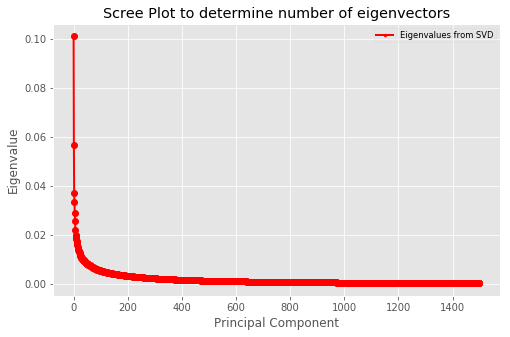

Wall time: 6.61 s


In [39]:
%%time
#--First, perform SVD to determine optimal number of components to use in LSA - use 'knee' of curve as cutoff
U, S, V = np.linalg.svd(PVSC_tfidfMat.todense()) 
eigvals = S**2 / np.cumsum(S)[-1]

#--Scree plot to identify 'knee' of curve to limit component number (can also use other cutoff, such as R^2 = 0.8)
fig = plt.figure(figsize=(8,5))
sing_vals = np.arange(0, len(eigvals), 1)
plt.plot(sing_vals, eigvals, 'ro-', linewidth=2)
plt.title('Scree Plot to determine number of eigenvectors')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
#I don't like the default legend so I typically make mine like below, e.g.
#with smaller fonts and a bit transparent so I do not cover up data, and make
#it moveable by the viewer in case upper-right is a bad place for it 
leg = plt.legend(['Eigenvalues from SVD'], loc='best', borderpad=0.3, 
                 shadow=False, prop=mpl.font_manager.FontProperties(size='small'),
                 markerscale=0.4)
leg.get_frame().set_alpha(0.4)
leg.draggable(state=True)
plt.show()

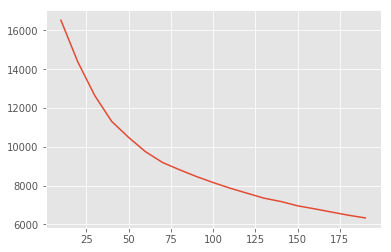

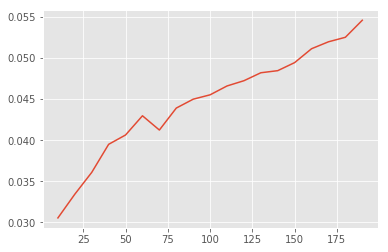

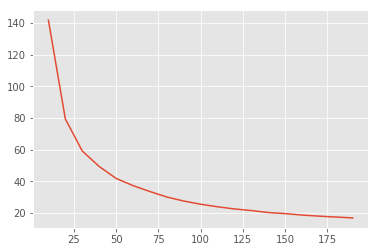

In [40]:
#Alternative method to confirm optimal cluster size:
#---Perform loop over number of SVD components that is also used as number of K-means clusters
#---Weight performance metrics by amount of variance explained by reduced SVD elements
#---Find peak or shift in slope of Inertia, SilScore, and C-H Score
#Use min and max SVD component values for loop
minSVD = 10
maxSVD = 200
intSVD = 10

#Perform loop for LSA + Kmeans calculation
inertiaLSA, silScoreLSA, chScoreLSA = LSAkmeansClusteringLoop(minSVD, maxSVD, intSVD, PVSC_tfidfMat)

#Plot results
x = np.arange(minSVD, maxSVD, intSVD)
plt.figure()
plt.plot(x, inertiaLSA)
plt.figure()
plt.plot(x, silScoreLSA)
plt.figure()
plt.plot(x, chScoreLSA)

In [41]:
#--LSA calculation
#-**INPUT PARAMETER**-#
#-First, create singular value decomposition object with desired number of components based on Scree plot analysis above
svdComponents = 150

#-Perform LSA
svdOut, LSAnormOut = LSAcalculation(svdComponents, PVSC_tfidfMat)

#-Set matrix for clustering equal to LSA output
PVSC_dist = LSAnormOut

#Output
print(LSAnormOut.shape)
svdOut.explained_variance_.sum()

#--IF NO LSA CALCULATION - USE THIS
#PVSC_dist_KM = PVSC_tfidfMat

(6862, 150)


0.48533051097534896

In [44]:
#---6) CLUSTERING---#

In [45]:
#-6A) K-MEANS CLUSTERING-#

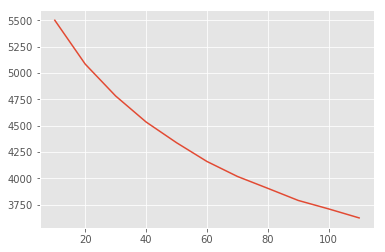

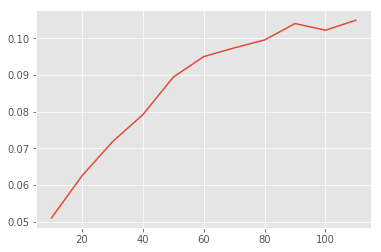

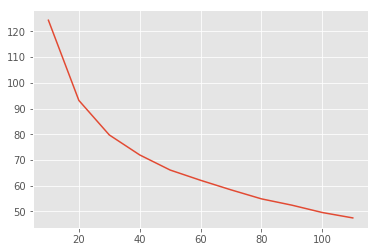

In [46]:
#--First, run loop to find optimal number of clusters using various metric scores WITHOUT TEST SET!
numClustMin = 10
numClustMax = 120
interval = 10

#-Perform k-means clustering across number of clusters determined from parameters above
inertiaList, silhouetteList, chScoreList = KMeansClusteringLoop(numClustMin, numClustMax, interval, PVSC_dist)

#-Plot results
x = np.arange(numClustMin,numClustMax,interval)
plt.figure()
plt.plot(x, inertiaList)
plt.figure()
plt.plot(x, silhouetteList)
plt.figure()
plt.plot(x, chScoreList)

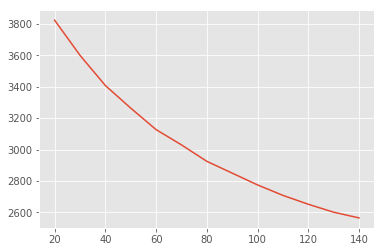

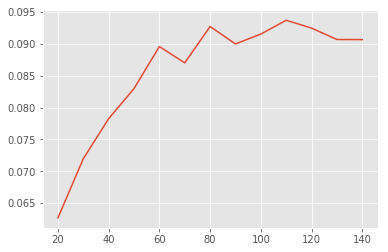

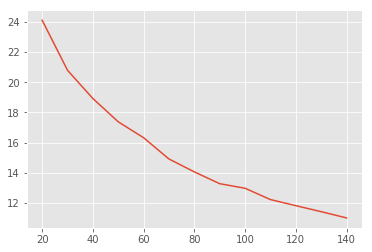

In [47]:
#--First, run loop to find optimal number of clusters using various metric scores USING TEST SET!
numClustMin = 20
numClustMax = 150
interval = 10

#-Perform k-means clustering across number of clusters determined from parameters above
inertiaList, silhouetteList, chScoreList = KMeansClusteringLoopTest(numClustMin, numClustMax, interval, PVSC_dist)

#-Plot results
x = np.arange(numClustMin,numClustMax,interval)
plt.figure()
plt.plot(x, inertiaList)
plt.figure()
plt.plot(x, silhouetteList)
plt.figure()
plt.plot(x, chScoreList)

In [48]:
#--Perform k-means clustering using optimal cluster number
#-**INPUT PARAMETER**-#
num_clusters_KM = 80 #optimal cluster number

#-Create K-means object
KMmodel = KMeans(n_clusters = num_clusters_KM)

#-Fit using LSA data
KMmodel.fit(PVSC_dist)

#-Create list of cluster labels
PVSC_KMlabels = KMmodel.labels_
KMlabels = KMmodel.labels_.tolist()

#-Add cluster labels as new colum in dataframe
PVSCabs['KM Cluster Label'] = KMmodel.labels_

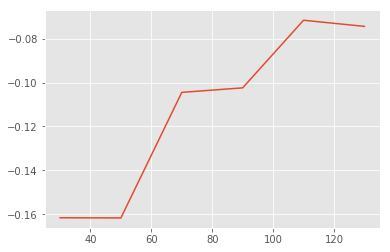

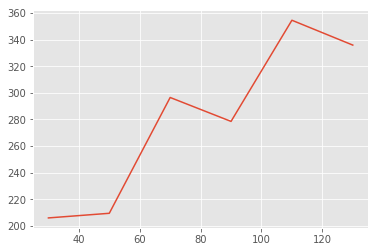

In [63]:
#Find optimal TSNE perplexity for given number of clusters determined above
minPerplex = 30
maxPerplex = 150
intPerplex = 20
inRandState = 1
TSNEsilList, TSNEchList = TSNEOptLoop(PVSC_dist, PVSC_KMlabels, num_clusters_KM, minPerplex, maxPerplex, intPerplex, inRandState)

x = np.arange(minPerplex,maxPerplex,intPerplex)
plt.figure()
plt.plot(x, TSNEsilList)
plt.figure()
plt.plot(x, TSNEchList)

In [49]:
#--Output vocabulary terms best representing each cluster, output to csv file
#-**INPUT PARAMETER**-#
num_words = 10
colTopic = 'Phrase'
dfClusterCatKM, listClusterCatKM = OutputClusterThemes(PVSCabs, PVSC_dist, svdOut, PVSC_vocab, dfTopicSet,
                                                       colTopic, KMmodel.cluster_centers_, num_clusters_KM,
                                                       num_words, 'KM')
dfClusterCatKM.to_csv("Themes_KM_"+inputAbs+nameApps+".csv")
dfClusterCatKM

,Phrase 0,Phrase 1,Phrase 2,Phrase 3,Phrase 4,Phrase 5,Phrase 6,Phrase 7,Phrase 8,Phrase 9,Document Count,Average Silhouette,StDev Silhouette
0,degradation,modules,induce degradation,degradation rates,data,test,accelerated,power,exposure,potential induced degradation,92,0.079316,0.068297
1,textured,surface,silicon,pyramidal,light trapping,surface texture,etching,randomization,optical,silicon solar cells,101,0.165788,0.083686
2,absorption,nanostructures,photons,light trapping,optical,plasmons,silicon,coated,film,surface,154,0.005602,0.041957
3,systems,pv systems,grid,energy,installed,power,grid connected,photovoltaic systems,data,modules,166,0.110396,0.078014
4,intermediate bands,ibsc,transition,absorption,quantum dots,photons,valence,bandgap,band gaps,modeled,56,0.193644,0.089431
5,oxidation,layers,passivation,silicon,surface,thermal,thermal oxidation,siox,tin oxide,type,54,0.061050,0.064416
6,power,systems,maximum power,control,mppt,power plants,energy,shading,algorithms,pv systems,107,0.068592,0.067847
7,cdte,cdte solar cells,devices,contacts,film,cds,cds cdte,layers,deposition,cdte thin films,176,0.097904,0.061341
8,diffusion,silicon,impurities,gettering,lifetime,boron,metallization,wafers,phosphorus,silicon solar cells,59,0.047546,0.065696
9,test,modules,accelerated,qualification,field,design,systems,procedures,power,reliable,62,0.099915,0.075778


In [50]:
#--Visualization

In [51]:
#Create TSNE-reduced corpus locations for plotting below
inPerp = 110
inExag = 1000
inRandState = 1
inLearn = 1000
inNumIter = 1000
outTSNE = TSNE(n_components = 2, random_state = inRandState, perplexity = inPerp,
                   early_exaggeration = inExag, learning_rate = inLearn, n_iter = inNumIter).fit_transform(PVSC_dist)

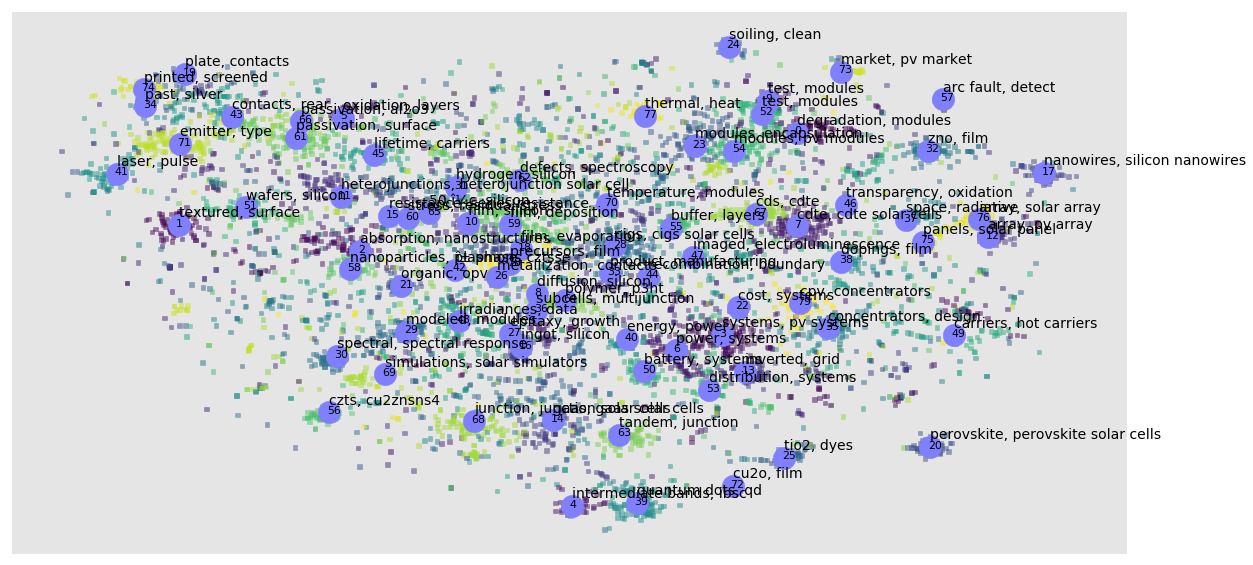

In [52]:
#Plot KM results using TSNE using dots to represent each corpus location
inAnnX = 0 #annotation shift in x
inAnnY = 1.25 #annotation shift in y
TSNEplot2D(outTSNE, PVSCabs, num_clusters_KM, 'KM', KMlabels, listClusterCatKM, inAnnX, inAnnY,  
           inPerp, inExag, inRandState, inLearn, inNumIter)

Wall time: 26.3 s


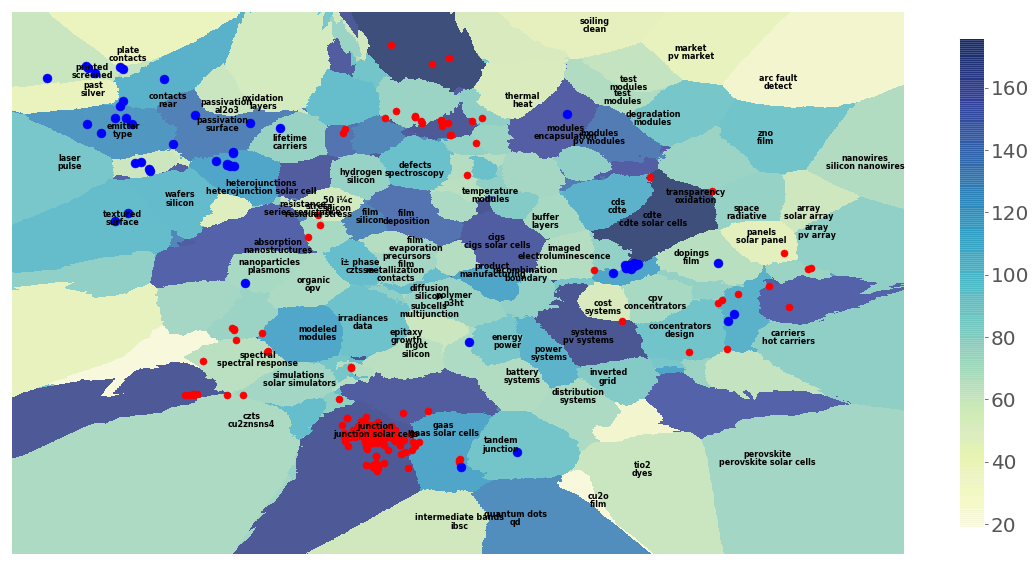

In [59]:
%%time
#Plot KM results using TSNE with mesh/region plotting
inAnnX = 0 #annotation shift in x
inAnnY = -1.8 #annotation shift in y
inFontSize = 8 #annotation font size
inLabelY = 1.2 #shift from cluser center for keyword locations
inMeshStep = 0.06 #mesh for KNN region definitions
inNumNN = 35 #nearest neighbors used for KNN for defining regions
inCmap = plt.cm.YlGnBu #colormap for regions
docSwitch = 'off' #show all documents as dots
clusterSwitch = 'on'
inIndClust = 68
centerSwitch = 'off'
countSwitch = 'on' #shade regions based on document count
authorSwitch = 'on' #highlight in orange those with specific author based on authorKeyword
authorKeyword = 'sunshot'
keywordSwitch = 'on' #highlight in red circles documents with keyword (or index if indexSwitch is on)
keyword = 'ibc'
colKeyword = titleGrouping
indexSwitch = 'off' #show index of highlighted documents (red dots)
fundingSwitch = 'off' #show funded applications in green, not funded in black (alt currently green as well)
inFoa = 'FPACE'
TSNEplot2Dmesh(outTSNE, PVSCabs, num_clusters_KM, 'KM', KMlabels, listClusterCatKM, dfClusterCatKM['Document Count'],
               inAnnX, inAnnY, inLabelY, inFontSize, inPerp, inExag, inRandState, inLearn, inNumIter, inMeshStep,
               inNumNN, inCmap, docSwitch, clusterSwitch, inIndClust, centerSwitch, countSwitch, indexSwitch,
               authorSwitch, authorKeyword, keywordSwitch, keyword, colKeyword, fundingSwitch, inFoa)

In [60]:
#Calculate distances between clusters and save to file - using distance function with dimensions equal to SVD components
dfKMdist = OutputDistances(num_clusters_KM, KMmodel.cluster_centers_, svdComponents)
dfKMdist.to_csv("Dist_KM_"+inputAbs+nameApps+".csv")

In [61]:
#Search for specific themes that came up
#ColumnSearchRowOut(PVSCabs, 'Misc Pub Info', 'SN')

In [62]:
#List all docs belonging to particular cluster
reportCluster = 68
for i in range(len(PVSCabs[PVSCabs['KM Cluster Label'] == reportCluster])):
    print(PVSCabs[PVSCabs['KM Cluster Label'] == reportCluster].index[i],
          PVSCabs[PVSCabs['KM Cluster Label'] == reportCluster]['Title'].iloc[i])

21 Inverted GaInP / (In)GaAs / InGaAs triple-junction solar cells with low-stress metamorphic bottom junctions
30 Monolithic integration of a p-n junction and porous silicon host matrix for next generation photovoltaics
45 Modeling of GaInP/GaAs Dual-Junction solar cells including Tunnel Junction
46 Electroluminescence characterization of IIIâV multi-junction solar cells
112 Numerical simulation of tunnel diodes and multi-junction solar cells
143 Multi-terminal dual junction InGaP2/GaAs solar cells for hybrid system
175 Correlation of current mismatch and fill factor in amorphous and nanocrystalline silicon based high efficiency multi-junction solar cells
179 Hydrogenated amorphous silicon and silicon germanium triple-junction solar cells at high rate using RF and VHF glow discharges
210 Development of metamorphic triple-junction solar cells for low temperature, low intensity operation in space
211 Characterization of radiation damage in multi-junction solar cells using light-biased 

In [63]:
#-6B) EXPECTATION MAXIMIZATION CLUSTERING-#

In [64]:
##--Expectation Maximization with Gaussian Mixture Model
#-Use same LSA results and vocabulary as K-Means

Wall time: 2min 51s


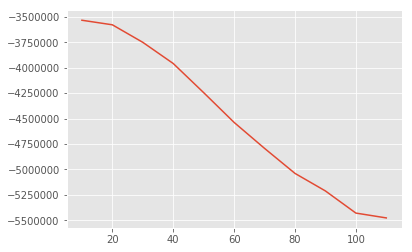

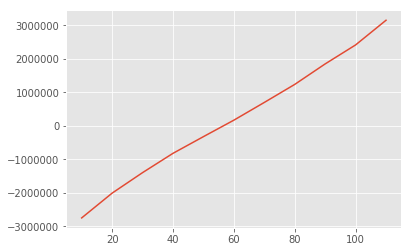

In [65]:
%%time
#--Testing - try expected maximization
numClustMinEM = 10
numClustMaxEM = 120
interval = 10

#-Run loop over all cluster numbers
listAIC, listBIC = EMloop(numClustMinEM, numClustMaxEM, interval, 'full', 500, PVSC_dist)

#-Output AIC and BIC scores to find optimal cluster number
plt.figure()
x = np.arange(numClustMinEM,numClustMaxEM,interval)
plt.plot(x, listAIC)
plt.figure()
plt.plot(x, listBIC)

Wall time: 1min 22s


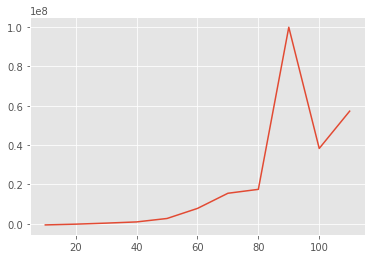

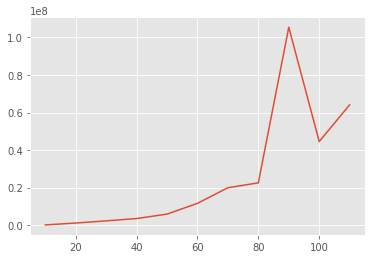

In [66]:
%%time
#--Testing - try expected maximization
numClustMinEM = 10
numClustMaxEM = 120
interval = 10

#-Run loop over all cluster numbers
listAIC, listBIC = EMloopTest(numClustMinEM, numClustMaxEM, interval, 'full', 500, PVSC_dist)

#-Output AIC and BIC scores to find optimal cluster number
plt.figure()
x = np.arange(numClustMinEM,numClustMaxEM,interval)
plt.plot(x, listAIC)
plt.figure()
plt.plot(x, listBIC)


In [69]:
#-**INPUT PARAMETER**-#
numClusters_EM = 60

#-Fit EM model with optimal cluster number
EMmodel = GaussianMixture(n_components=numClusters_EM, covariance_type='full', max_iter=500, init_params='kmeans')
EMmodel.fit(PVSC_dist)

#-Save cluster labels for each doc in corpus for later visualization
EMlabels = EMmodel.predict(PVSC_dist).tolist()

#-Add cluster labels as new colum in dataframe
PVSCabs['EM Cluster Label'] = EMlabels

In [70]:
#--Output vocabulary terms best representing each cluster, output to csv file
#-**INPUT PARAMETER**-#
numWordsEM = 10
colTopic = 'Phrase'
dfClusterCatEM, listClusterCatEM = OutputClusterThemes(PVSCabs, PVSC_dist, svdOut, PVSC_vocab, dfTopicSet,
                                                       colTopic, EMmodel.means_, numClusters_EM,
                                                       numWordsEM, 'EM')
dfClusterCatEM.to_csv("Themes_EM_"+inputAbs+nameApps+".csv")
dfClusterCatEM

,Phrase 0,Phrase 1,Phrase 2,Phrase 3,Phrase 4,Phrase 5,Phrase 6,Phrase 7,Phrase 8,Phrase 9,Document Count,Average Silhouette,StDev Silhouette
0,epitaxy,grown,substrates,growth,layers,beam,iii,film,gaas,silicon,124,0.048012,0.047320
1,test,arc fault,detect,systems,pv systems,firing,modules,frequency,accelerated,algorithms,64,0.078704,0.081368
2,wafers,silicon,stress,surface,cost,cracks,wires,type,etching,textured,107,0.092297,0.082508
3,zno,film,deposition,layers,zno al,zno films,dopings,oxidation,tco,nanorods,104,0.150107,0.075900
4,boundary,cdte,gbs,recombination,polycrystalline,atom,probe,film,imaged,15% multicrystalline,45,0.160235,0.088380
5,precursors,film,cztsse,î± phase,absorbers,devices,annealing,reactions,sulfur,sputtering,105,0.072124,0.060861
6,devices,nanoparticles,layers,absorption,optical,plasmons,surface,metallization,absorbers,nanostructures,395,-0.055270,0.027862
7,deposition,film,sputtering,substrates,temperature,glass,oxidation,targeted,layers,annealing,134,0.050395,0.045117
8,product,manufacturing,cost,market,modules,price,pv market,grid,installed,silicon,120,0.035562,0.056133
9,rear,passivation,contacts,printed,surface,local,screened,type,wafers,dielectric,86,0.107271,0.061404


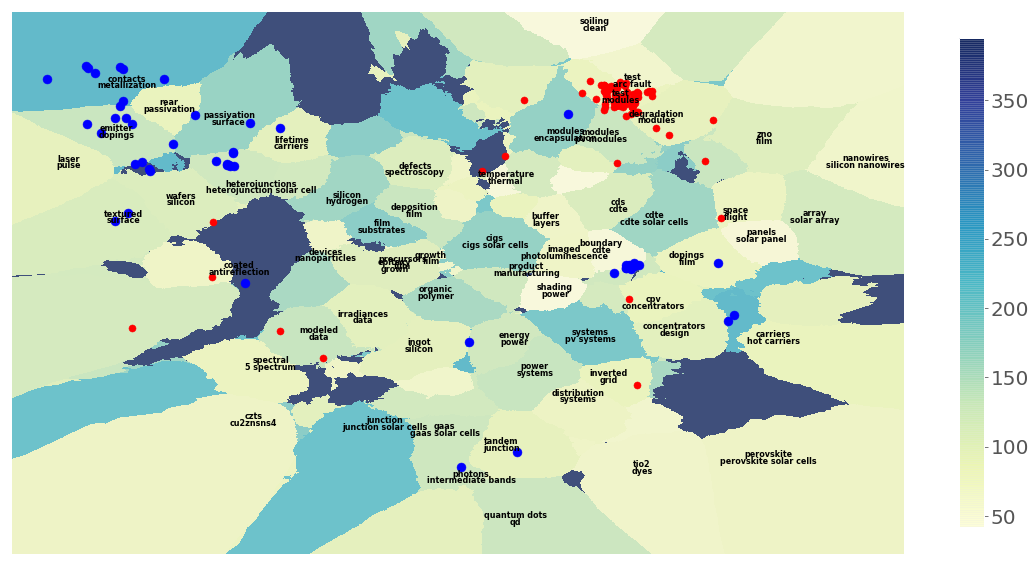

In [71]:
#Plot EM results using TSNE mesh plotter
inAnnX = 0 #annotation shift in x
inAnnY = -1.8 #annotation shift in y
inFontSize = 8 #annotation font size
inLabelY = 1.0 #shift from cluser center for keyword locations
inMeshStep = 0.05 #mesh for KNN region definitions
inNumNN = 35 #nearest neighbors used for KNN for defining regions
inCmap = plt.cm.YlGnBu #colormap for regions
docSwitch = 'off' #show all documents as dots
clusterSwitch = 'on'
inIndClust = 37
centerSwitch = 'off'
countSwitch = 'on' #shade regions based on document count
authorSwitch = 'off' #highlight in orange those with specific author based on authorKeyword
authorKeyword = 'sunshot'
keywordSwitch = 'on' #highlight in red circles documents with keyword (or index if indexSwitch is on)
keyword = 'ibc'
colKeyword = titleGrouping
indexSwitch = 'off' #show index of highlighted documents (red dots)
fundingSwitch = 'off' #show funded applications in green, not funded in black (alt currently green as well)
inFoa = 'FPACE'
TSNEplot2Dmesh(outTSNE, PVSCabs, numClusters_EM, 'EM', EMlabels, listClusterCatEM, dfClusterCatEM['Document Count'],
               inAnnX, inAnnY, inLabelY, inFontSize, inPerp, inExag, inRandState, inLearn, inNumIter, inMeshStep,
               inNumNN, inCmap, docSwitch, clusterSwitch, inIndClust, centerSwitch, countSwitch, indexSwitch,
               authorSwitch, authorKeyword, keywordSwitch, keyword, colKeyword, fundingSwitch, inFoa)

In [72]:
#Calculate distances between clusters and save to file - using distance function with dimensions equal to SVD components
dfEMdist = OutputDistances(numClusters_EM, EMmodel.means_, svdComponents)
dfEMdist.to_csv("Dist_EM_"+inputAbs+nameApps+".csv")

In [73]:
#Search for specific themes that came up
#ColumnSearchRowOut(PVSCabs, 'Title and Abstract', 'hybrid hot carrier')

In [74]:
#List all docs belonging to particular cluster
reportCluster = 37
for i in range(len(PVSCabs[PVSCabs['EM Cluster Label'] == reportCluster])):
    print(PVSCabs[PVSCabs['EM Cluster Label'] == reportCluster].index[i],
          PVSCabs[PVSCabs['EM Cluster Label'] == reportCluster]['Title'].iloc[i])

335 Failure analysis of design qualification testing: 2007 VS. 2005
337 The effect of cell thickness on module reliability
338 Accelerated UV test methods and selection criteria for encapsulants of photovoltaic modules
598 A lifetime prediction of PV encapsulant and backsheet via time temperature superposition principle
684 The effect of metal foil tape degradation on the long-term reliability of PV modules
955 Assessment of ageing through periodic exposure to damp heat (85Â°c / 85 % RH) of seven different thin-film module types
983 Further investigation of the lifetime-limiting failure mechanisms of CIGSS-based minimodules under environmental stress
1063 Test-to-Failure of crystalline silicon modules
1064 Failure analysis of module design qualification testing - III: 1997â2005 vs. 2005â2007 vs. 2007â2009
1110 HCPV tracker accelerated reliability tests
1160 Thin specialty glass for reliable thin film PV modules
1237 Intrinsic stability of thin-film CdS/CdTe modules
1531 Impacts o

In [75]:
#Write PVSCabs dataframe to file to analyze individual documents with cluster labels
dataOutput = PVSCabs.drop(['Abstract', titleGrouping], axis=1)
dataOutput.to_csv("DF_"+inputAbs+nameApps+".csv")

In [76]:
#Save and output matrices of distances between all cluster centers

In [77]:
#-7) Latent Dirichlet Alternative to LSA for Topic Modeling

In [ ]:
import gensim
import pickle

# Convert sparse TFIDF matrix to gensim corpus.
corpusGensim = gensim.matutils.Sparse2Corpus(PVSC_tfidfMat, documents_columns=False)
# Mapping from vocabulary IDs to vocabulary words (To be used in LdaModel's id2word parameter)
idMap = dict((v, k) for k, v in tfidfVect.vocabulary_.items())

In [ ]:
#Optimize number of topics for LDA using perplexity rate of change
#--Input Parameters
numCV = 5
minTopics = 60
maxTopics = 230
interval = 10
passes = 10
randomState = None
#--Perform loop as funciton of number of topics
numTopics, perpMean, perpStd, perpRate = LDAPerplexityChangeLoop(numCV, minTopics, maxTopics, interval, PVSC_tfidfMat,
                                                                 passes, randomState)

In [ ]:
#Plot perplexity and its rate of change as function of topic number to find optimal (when rate becomes approx constant)
plt.figure()
plt.plot(numTopics, perpMean)
plt.figure()
plt.plot(numTopics, perpStd)
plt.figure()
plt.plot(numTopics[1:], perpRate)

In [ ]:
# LDA fitting
ldaModel = gensim.models.ldamodel.LdaModel(corpusGensim, num_topics=220, id2word = idMap, passes=25,
                                           minimum_probability = 0.01, random_state=None)

In [ ]:
ldaModel.print_topics(num_topics = 220, num_words = 5)

In [ ]:
ldaDocTopicMat = LdaGensimToNumpy(corpusGensim, ldaModel, 140)

In [ ]:
%%time
#--First, run loop to find optimal number of clusters using various metric scores
numClustMin = 30
numClustMax = 130
interval = 10

#-Perform k-means clustering across number of clusters determined from parameters above
inertiaListLDA, silhouetteListLDA, chScoreListLDA = KMeansClusteringLoop(numClustMin, numClustMax, interval, ldaDocTopicMat)

#-Plot results
x = np.arange(numClustMin,numClustMax,interval)
plt.figure()
plt.plot(x, inertiaListLDA)
plt.figure()
plt.plot(x, silhouetteListLDA)
plt.figure()
plt.plot(x, chScoreListLDA)

In [ ]:
#--Perform k-means clustering using optimal cluster number
#-**INPUT PARAMETER**-#
num_clusters_LDA_KM = 90 #optimal cluster number

#-Create K-means object
KMmodelLDA = KMeans(n_clusters = num_clusters_LDA_KM)

#-Fit using LSA data
KMmodelLDA.fit(ldaDocTopicMat)

#-Create list of cluster labels
PVSC_KMlabels_LDA = KMmodelLDA.labels_
KMlabelsLDA = KMmodelLDA.labels_.tolist()

#-Add cluster labels as new colum in dataframe
PVSCabs['LDA KM Cluster Label'] = KMmodelLDA.labels_

In [ ]:
#Use temporarily for TSNE plotting below to color by number
dfLDA = pd.DataFrame(KMlabelsLDA, columns = ['Cluster Number'])
dfLDA['Count'] = 1
dfLDAcount = dfLDA.groupby('Cluster Number').count()['Count']

In [ ]:
PVSCabs

In [ ]:
#Find optimal TSNE perplexity for given number of clusters determined above
minPerplex = 10
maxPerplex = 100
intPerplex = 10
inRandState = 1
TSNEsilListLDA, TSNEchListLDA = TSNEOptLoop(ldaDocTopicMat, PVSC_KMlabels_LDA, num_clusters_LDA_KM,
                                      minPerplex, maxPerplex, intPerplex, inRandState)

x = np.arange(minPerplex,maxPerplex,intPerplex)
plt.figure()
plt.plot(x, TSNEsilListLDA)
plt.figure()
plt.plot(x, TSNEchListLDA)

In [ ]:
#NEED DIFFERNT WAY OF GETTING VOCAB TERMS SINCE DIDN"T USE TRANSFORMATION
#--Output vocabulary terms best representing each cluster, output to csv file
#-**INPUT PARAMETER**-#
#num_words = 10
#colTopic = 'Phrase'
#dfClusterCatKM, listClusterCatKM = OutputClusterThemes(PVSCabs, PVSC_dist, svdOut, PVSC_vocab, dfTopicSet,
#                                                       colTopic, KMmodel.cluster_centers_, num_clusters_KM,
#                                                       num_words, 'KM')
#dfClusterCatKM.to_csv("Themes_KM_"+inputAbs+inputFOAs+inputApps+".csv")
#dfClusterCatKM

In [ ]:
#-VISUALIZATION-#

In [ ]:
#Create TSNE-reduced corpus locations for plotting below
inPerp = 100
inExag = 1000
inRandState = 1
inLearn = 1000
inNumIter = 1000
outTSNELDA = TSNE(n_components = 2, random_state = inRandState, perplexity = inPerp,
                   early_exaggeration = inExag, learning_rate = inLearn, n_iter = inNumIter).fit_transform(ldaDocTopicMat)

In [ ]:
itemPick = 25
KMlabelsLDABinary = [1 if item == itemPick else 0 for item in KMlabelsLDA]
plt.figure(figsize=(10,10))
#plt.scatter(outTSNELDA[:,0], outTSNELDA[:,1], c = KMlabelsLDABinary)
plt.scatter(outTSNELDA[:,0], outTSNELDA[:,1], c = KMlabelsLDA)

In [ ]:
#Plot EM results using TSNE mesh plotter
inAnnX = 0 #annotation shift in x
inAnnY = -1.8 #annotation shift in y
inFontSize = 8 #annotation font size
inLabelY = 0.40 #shift from cluser center for keyword locations
inMeshStep = 0.03 #mesh for KNN region definitions
inNumNN = 40 #nearest neighbors used for KNN for defining regions
inCmap = plt.cm.YlGnBu #colormap for regions
docSwitch = 'off' #show all documents as dots
clusterSwitch = 'on'
inIndClust = 3
centerSwitch = 'off'
countSwitch = 'on' #shade regions based on document count
authorSwitch = 'off' #highlight in orange those with specific author based on authorKeyword
authorKeyword = 'sunshot'
keywordSwitch = 'on' #highlight in red circles documents with keyword (or index if indexSwitch is on)
keyword = 'ibc'
colKeyword = titleGrouping
indexSwitch = 'off' #show index of highlighted documents (red dots)
fundingSwitch = 'off' #show funded applications in green, not funded in black (alt currently green as well)
inFoa = 'FPACE'
listClusterCatKMLDA = []
TSNEplot2Dmesh(outTSNELDA, PVSCabs, num_clusters_LDA_KM, 'KM', KMlabelsLDA, listClusterCatKMLDA, dfLDAcount,
               inAnnX, inAnnY, inLabelY, inFontSize, inPerp, inExag, inRandState, inLearn, inNumIter, inMeshStep,
               inNumNN, inCmap, docSwitch, clusterSwitch, inIndClust, centerSwitch, countSwitch, indexSwitch,
               authorSwitch, authorKeyword, keywordSwitch, keyword, colKeyword, fundingSwitch, inFoa)

In [ ]:
#List all docs belonging to particular cluster
reportCluster = 3
for i in range(len(PVSCabs[PVSCabs['LDA KM Cluster Label'] == reportCluster])):
    print(PVSCabs[PVSCabs['LDA KM Cluster Label'] == reportCluster].index[i],
          PVSCabs[PVSCabs['LDA KM Cluster Label'] == reportCluster]['Title'].iloc[i])